# 全国智能电表第四类故障预测
## 数据说明
* 全国智能电表第四类故障数据
* 数据属性：**省份** **供电单位** **设备规格** **供应商** **安装月份** **故障月份** **使用时长** **通讯方式** **库存时间** **批次**
* 分类准确度：top1：0.71  top2：0.865 top3:0.927 

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage,fclusterdata
from scipy.sparse import coo_matrix, bmat
from sklearn import preprocessing
%matplotlib inline

# 参数设置

In [2]:
PLOT = True  #是否画图

# Data Explore

In [3]:
data = pd.read_csv('~/bigdata/data/all_3.csv', dtype={0:object, 'ORG':object, 'SPEC_CODE':object, 'MANUFACTURER':object,
                                                  'FAULT_MONTH':int, 'INST_MONTH':object, 'FAULT_QUARTER':object, 
                                                  'FAULT_TYPE': object,'SYNC_ORG_NO':object,'ORG_NO':object
                                              
                                                 }, encoding='utf-8')

#preview the zhejiang_4 data
data.head()

/home/hadoop/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,EQUIP_ID,FAULT_TYPE,SYNC_ORG_NO,ORG_NO,ORG_NAME,SPEC_CODE,COMM_MODE,ARRIVE_BATCH_NO,MANUFACTURER,FAULT_DATE1,INST_DATE1,DETECT_DATE1,FAULT_MONTH,INST_MONTH,work_month,save_day,FAULT_TYPE_1
0,904116,411,22101,2240101,客户服务中心(营销部),101,3,10000000000000000,578,2015-06-01,2009-09-16,2009-09-14,6,9.0,69.0,0.0,4
1,1489695,404,61101,61102,陕西省电力公司,113,2,200987479406,924,2015-11-18,NaN,2012-12-29,11,NaN,50.0,-13.0,4
2,1505752,409,61101,61102,陕西省电力公司,113,2,200987479406,924,2015-12-18,NaN,2012-12-29,12,NaN,59.0,6.0,4
3,2376871,409,61101,61102,陕西省电力公司,118,2,200987479531,825,2015-12-18,NaN,2010-10-19,12,NaN,45.0,-22.0,4
4,2376894,409,61101,61102,陕西省电力公司,113,2,200987479406,924,2015-12-18,NaN,2012-12-29,12,NaN,24.0,-1.0,4


# feature preprocessing

In [4]:
data.drop([data.columns[0]], axis=1, inplace=True)
#data.drop_duplicates(['FAULT_TYPE', 'ORG_NO', 'SPEC_CODE', 'COMM_MODE', 'MANUFACTURER', 'FAULT_MONTH',
 #                    'INST_MONTH', 'month'], inplace=True)

In [5]:
data['FAULT_TYPE'].value_counts()

409    127096
411     76257
407     71985
408     57424
404     54128
401     35836
410     17851
402     17329
405      4914
406      3643
403      2377
Name: FAULT_TYPE, dtype: int64

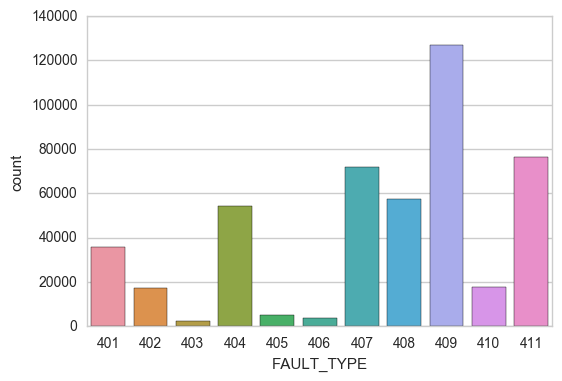

In [6]:
fig, axis0 = plt.subplots(1, 1)
sns.countplot(x='FAULT_TYPE', data=data, ax=axis0)

从故障类型柱状图可以看出故障类型数据不平衡，403,405,406,410较少，希望后续提供更多此类数据。

## SYNC_ORG_NO

count     468840
unique        22
top        33101
freq      185047
Name: SYNC_ORG_NO, dtype: object


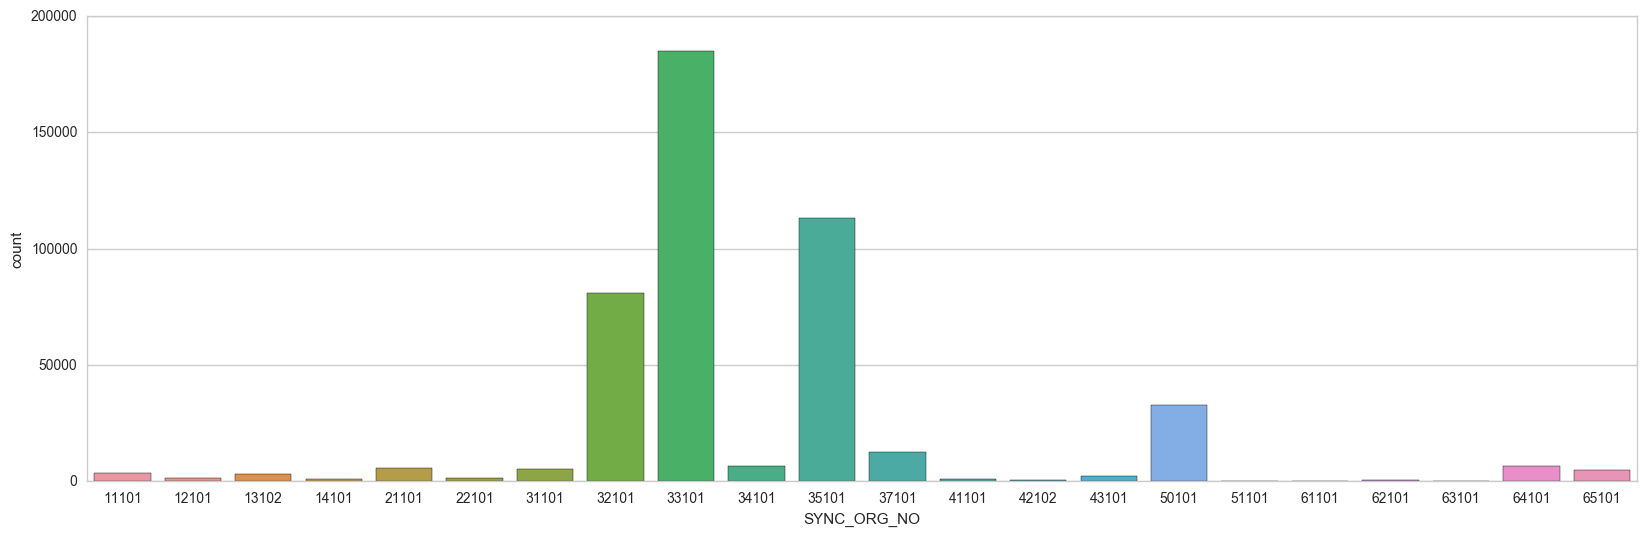

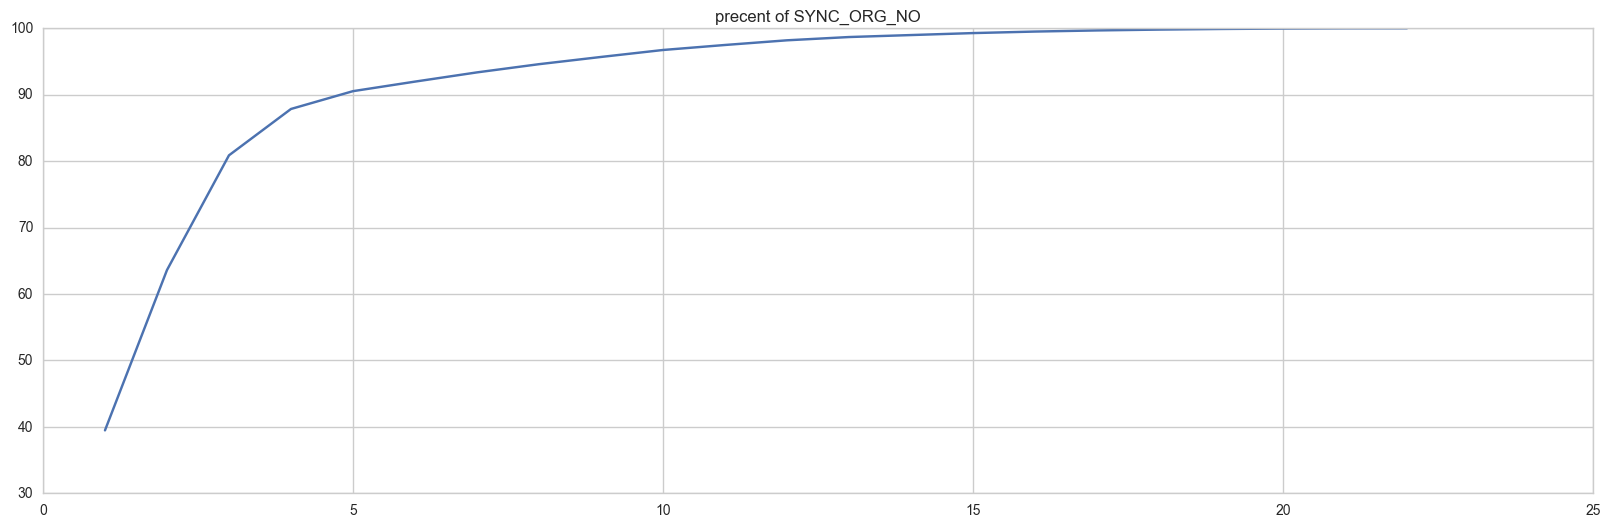

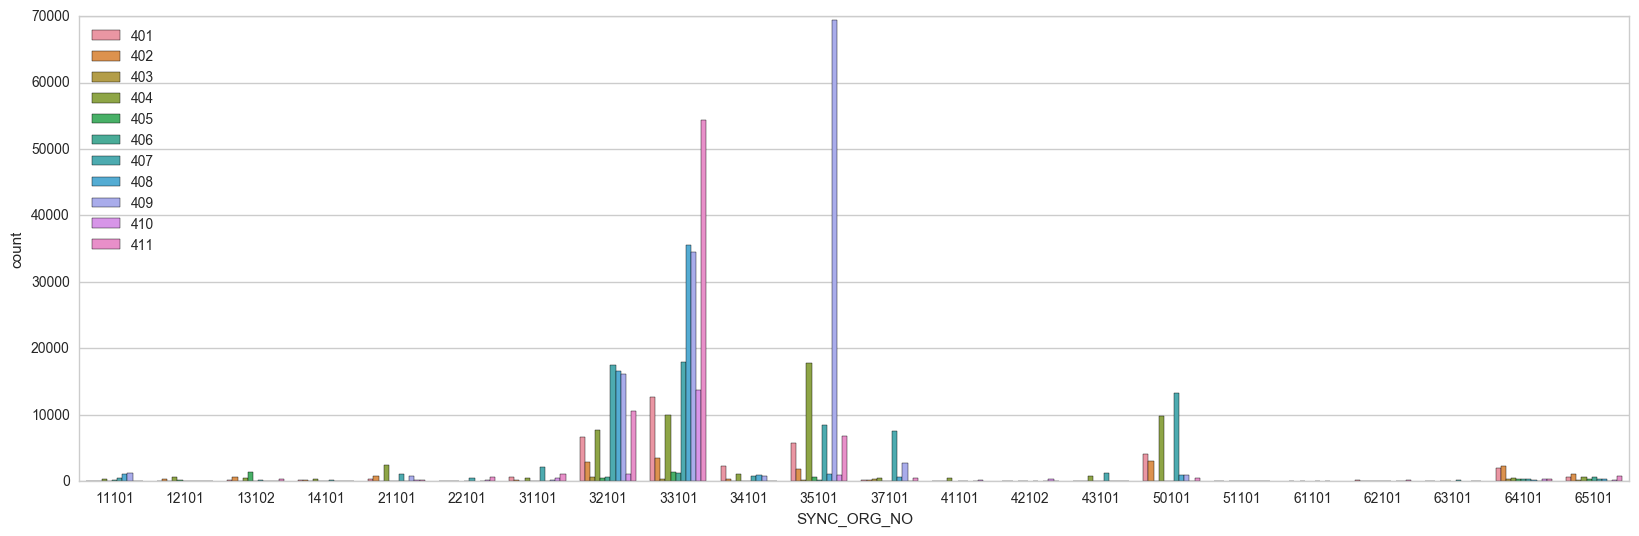

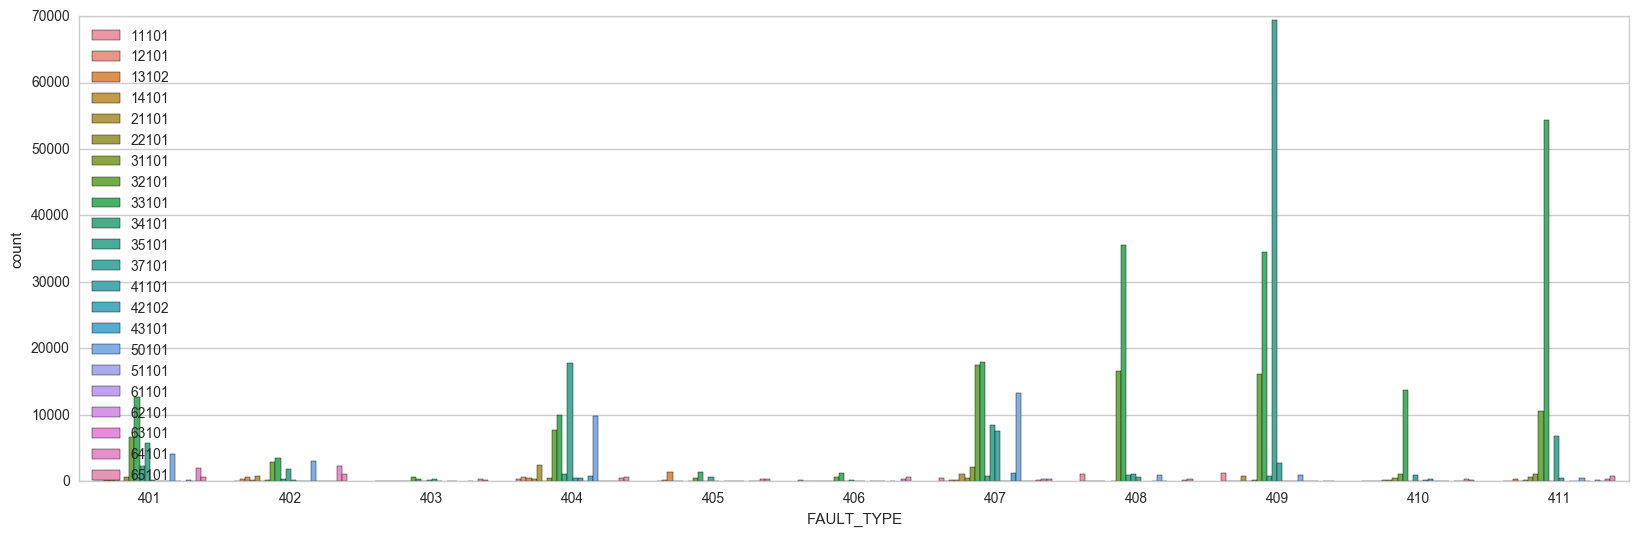

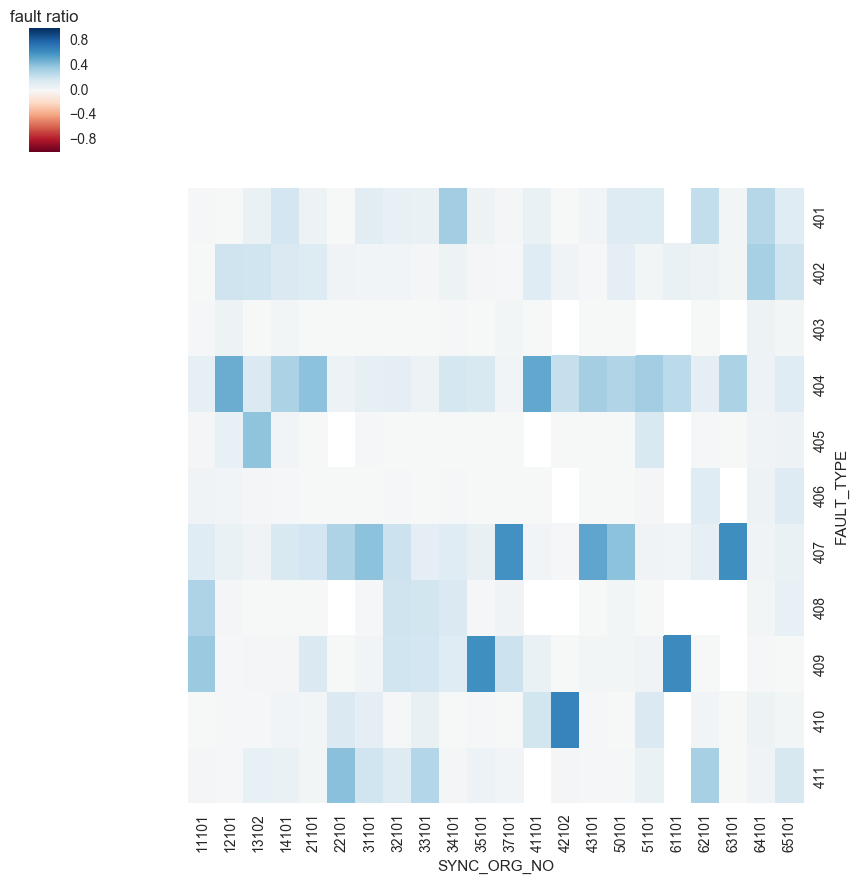

In [7]:
#ORG
print data['SYNC_ORG_NO'].describe()
#plot
def plot_fun(name_fea, name_fault, figsize=None, fontsize=None):
    
    
    fig1 = plt.figure(figsize=figsize, dpi=100)
    ax1 = fig1.add_subplot(111)
    sns.countplot(x=name_fea, data=data, ax = ax1)
    
    fig2 = plt.figure(figsize=figsize, dpi=100)
    ax2 = fig2.add_subplot(111)
    c = data[name_fea].value_counts()
    s = c.cumsum()/c.sum()
    ax2.plot(np.arange(s.shape[0])+1, s.values*100)
    ax2.set_title('precent of %s'%name_fea)
    
    fig3 = plt.figure(figsize=figsize, dpi=100)
    ax3 = fig3.add_subplot(111)
    sns.countplot(x=name_fea, hue=name_fault, data=data, ax=ax3)
    plt.legend(loc = 2)
    fig4 = plt.figure(figsize=figsize, dpi=100)
    ax4 = fig4.add_subplot(111)
    sns.countplot(x=name_fault, hue=name_fea, data=data, ax=ax4)
    plt.legend(loc = 2, fontsize=fontsize)

    #calculate similar score
    from scipy.cluster.hierarchy import dendrogram, linkage    
    #clustermap

    fault_num1 = data.groupby([name_fault, name_fea])[data.columns[0]].count().unstack()

    ratio = fault_num1 / fault_num1.sum()  

    g1 = sns.clustermap(ratio, 
                        cmap=plt.get_cmap('RdBu'),
                        vmax=1,
                        vmin=-1,
                        linewidth=0,
                        figsize=(10, 10),
                        row_cluster=False,
                        col_cluster=False
                    )
    plt.title('fault ratio')

#聚类函数
def cluster_encoding(name):
    global data
    fault_num = data.groupby(['FAULT_TYPE', name])[data.columns[0]].count().unstack()
    MAN_ratio = fault_num / fault_num.sum()
    MAN_ratio_T = MAN_ratio.T

    clusters = fclusterdata(np.array(MAN_ratio_T), 1)
    print clusters.shape
    clusters_mapping = {label:idx for label,idx in zip(MAN_ratio.columns, clusters)}
    data[name] = data[name].map(clusters_mapping)
#编码函数
def onehot_pre(name):
    global data
    le  = preprocessing.LabelEncoder()
    le.fit(data[name])
    cat_name = list(le.classes_)
    data[name] = le.transform(data[name])
    return cat_name
#plot
if PLOT:
    plot_fun('SYNC_ORG_NO', 'FAULT_TYPE',figsize=(20,6))
#get_dummies
SYNC_ORG_dummies = coo_matrix(pd.get_dummies(data['SYNC_ORG_NO']))

## 省份故障类型统计
* 图1为省份数量分布图，有四个省的故障数据比较集中。
* 图2为省份故障数量占比图，故障数据主要集中在前5个省，占比达90%
* 图3为省份-故障类型数量图，每个省的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为故障类型-省份图，每种故障类型在每个省的分布不同
* 图5为省份-故障类型占比图，可以看出每个省份故障类型比例，可以用于相似省份聚类

count     468840
unique      3123
top        35401
freq       25336
Name: ORG_NO, dtype: object
(468840, 575)


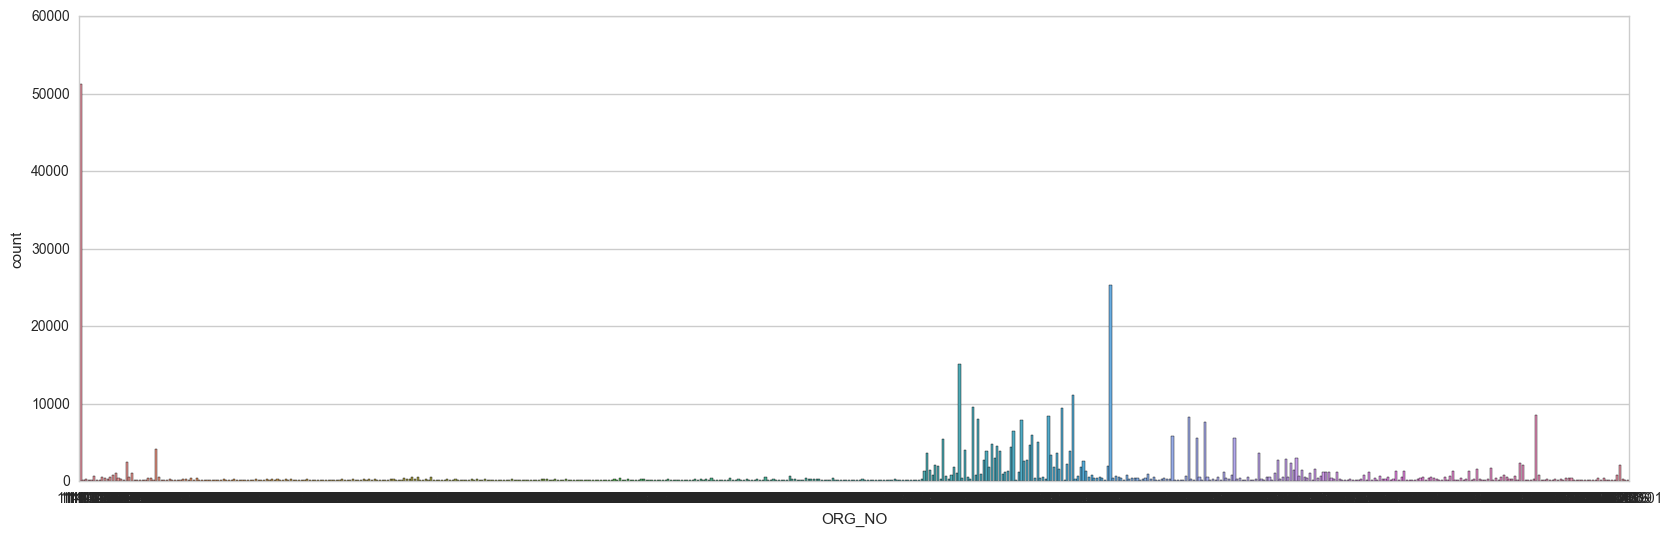

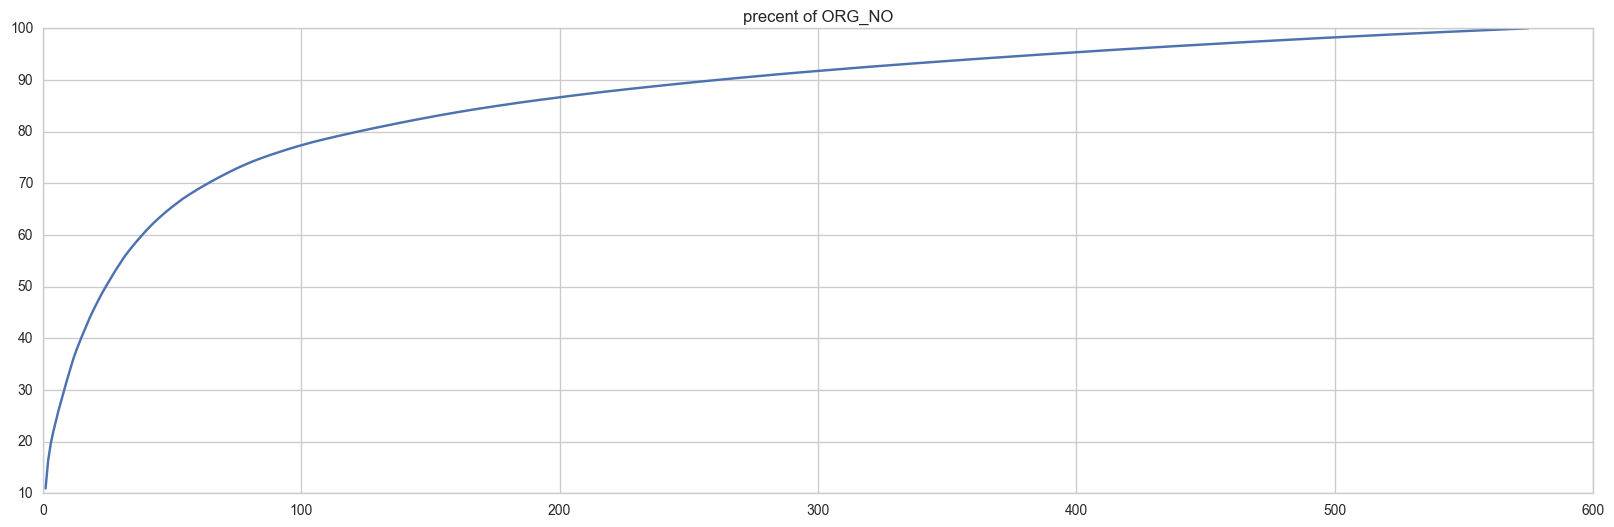

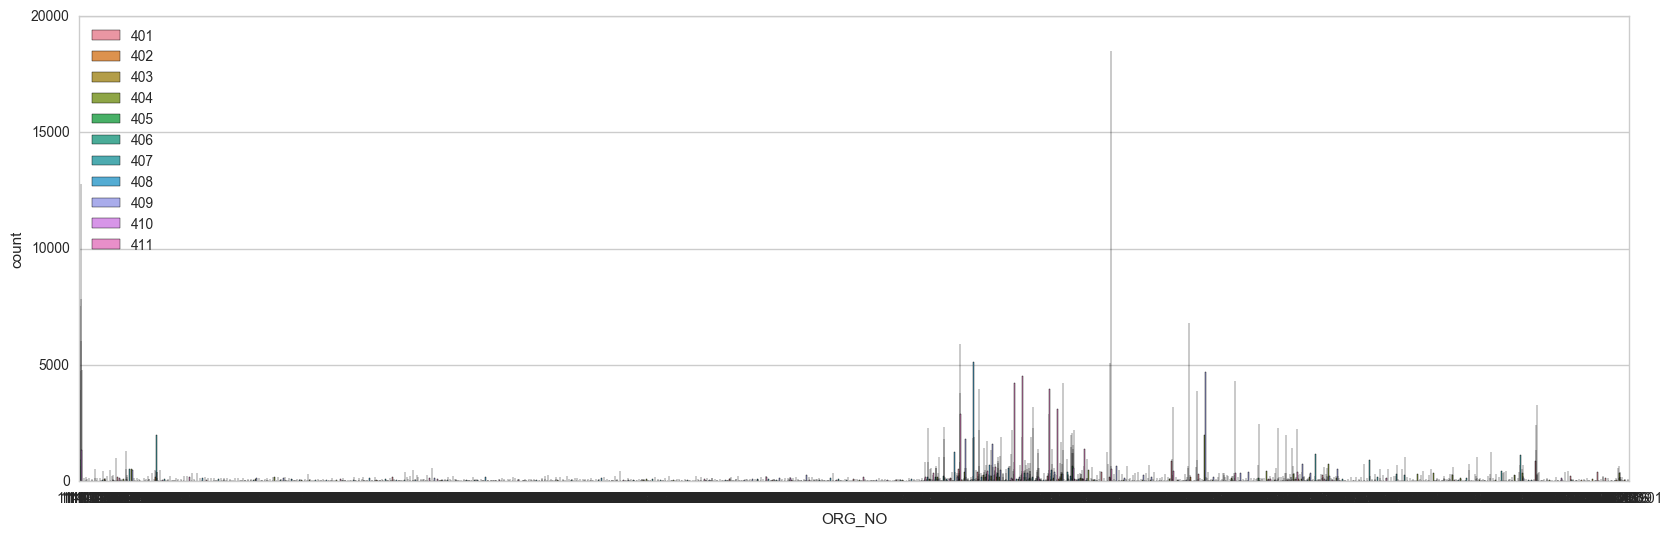

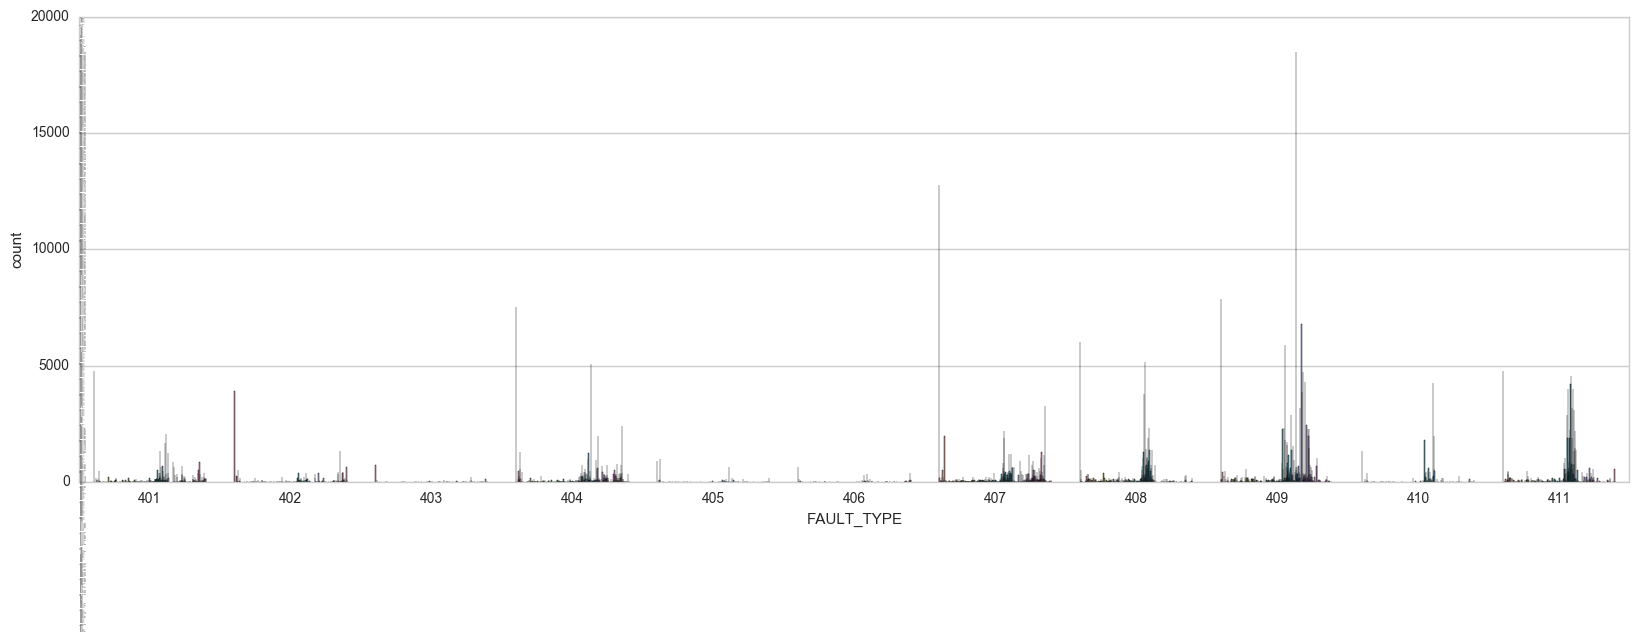

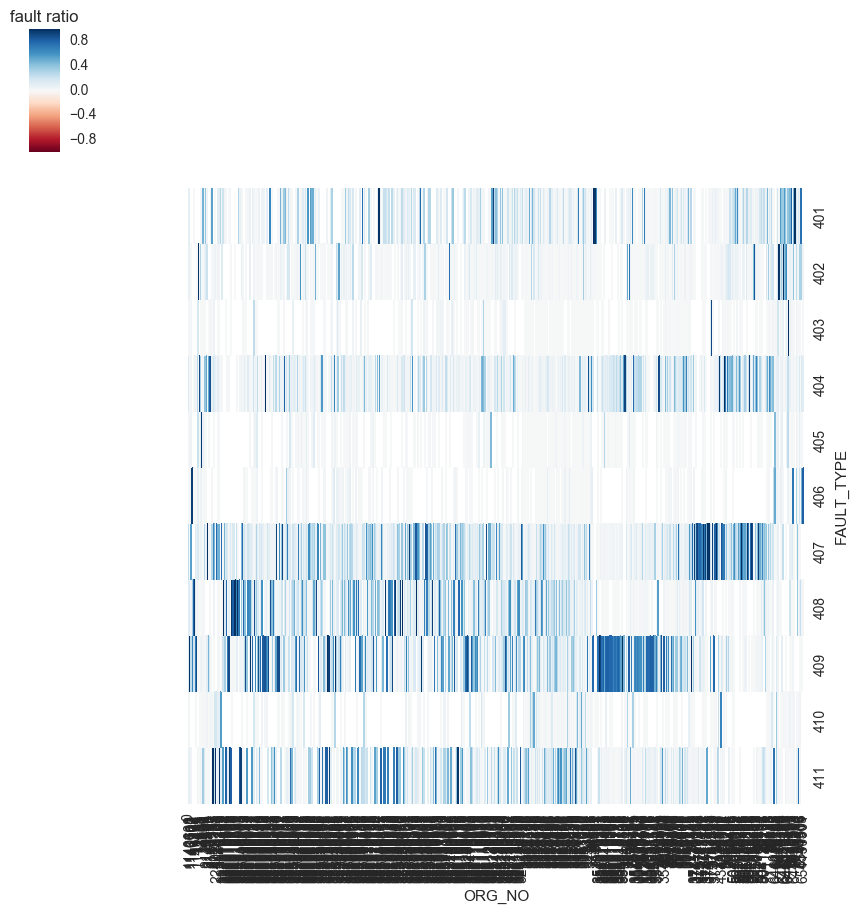

In [8]:
#ORG
print data['ORG_NO'].describe()
#plot
#get_dummies
ORG_freq = data['ORG_NO'].value_counts().index[data['ORG_NO'].value_counts().values<100]
data['ORG_NO'] = data['ORG_NO'].replace(ORG_freq.values, 0)

if PLOT:
    plot_fun('ORG_NO', 'FAULT_TYPE', figsize=(20,6),fontsize=0.1)

ORG_dummies = coo_matrix(pd.get_dummies(data['ORG_NO']))# 转化为稀疏矩阵
#ORG_dummies.drop(['33101', '33407', '33411'], axis=1, inplace=True)
print ORG_dummies.shape

## 供电单位故障类型统计
* 图1为供电单位数量分布图，分布呈现出故障在部分供电单位集中出现，均匀少量的出现在其他区域，且供电单位数量庞大。
* 图2为供电单位故障数量占比图，故障数据主要集中在100个供电单位，占比达80%
* 图3为供电单位-故障类型数量图，每个供电单位的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为故障类型-供电单位图，每种故障类型在每个供电单位的分布不同
* 图5为供电单位-故障类型占比图，可以看出每个供电单位故障类型比例，可以用于相似供电单位聚类
* 对属性做了二元变换处理

## SPEC_CODE

In [9]:
#SPEC_CODE
data['SPEC_CODE'].describe()

count     468840
unique        34
top          102
freq      257260
Name: SPEC_CODE, dtype: object

In [10]:
data['SPEC_CODE'].value_counts()

102    257260
100     84538
101     58873
118     23678
104      6180
103      6031
106      5548
121      5265
112      4609
108      4276
115      2966
131      2543
129      1648
113      1448
116       996
125       846
119       535
109       313
123       295
130       222
107       203
122       107
135        96
           75
110        67
136        61
126        50
138        40
139        29
111        26
127         7
134         6
132         2
140         1
Name: SPEC_CODE, dtype: int64

[u'135' u' ' u'110' u'136' u'126' u'138' u'139' u'111' u'127' u'134' u'132'
 u'140']


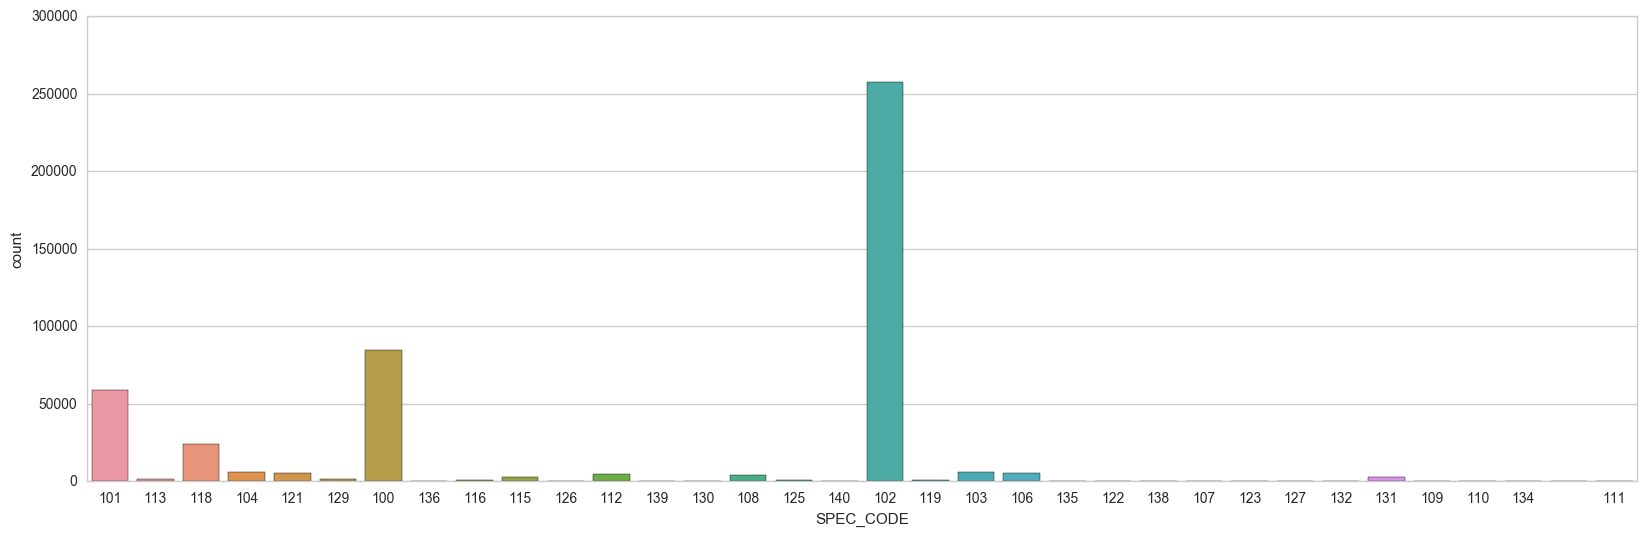

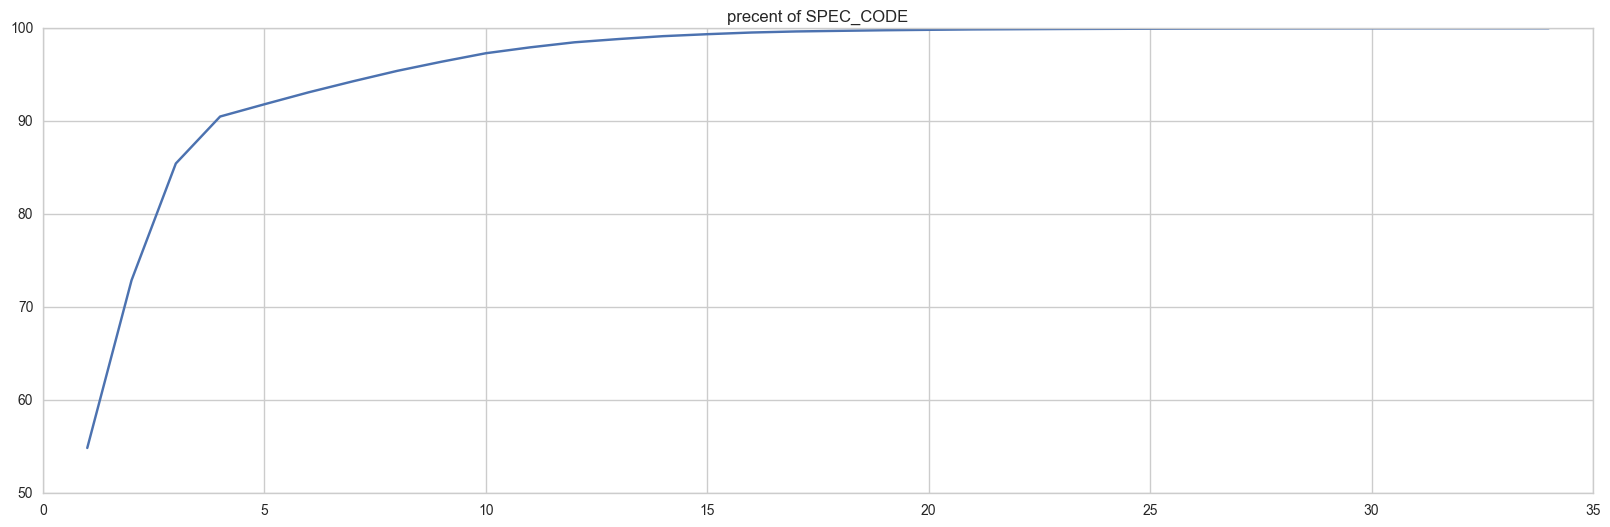

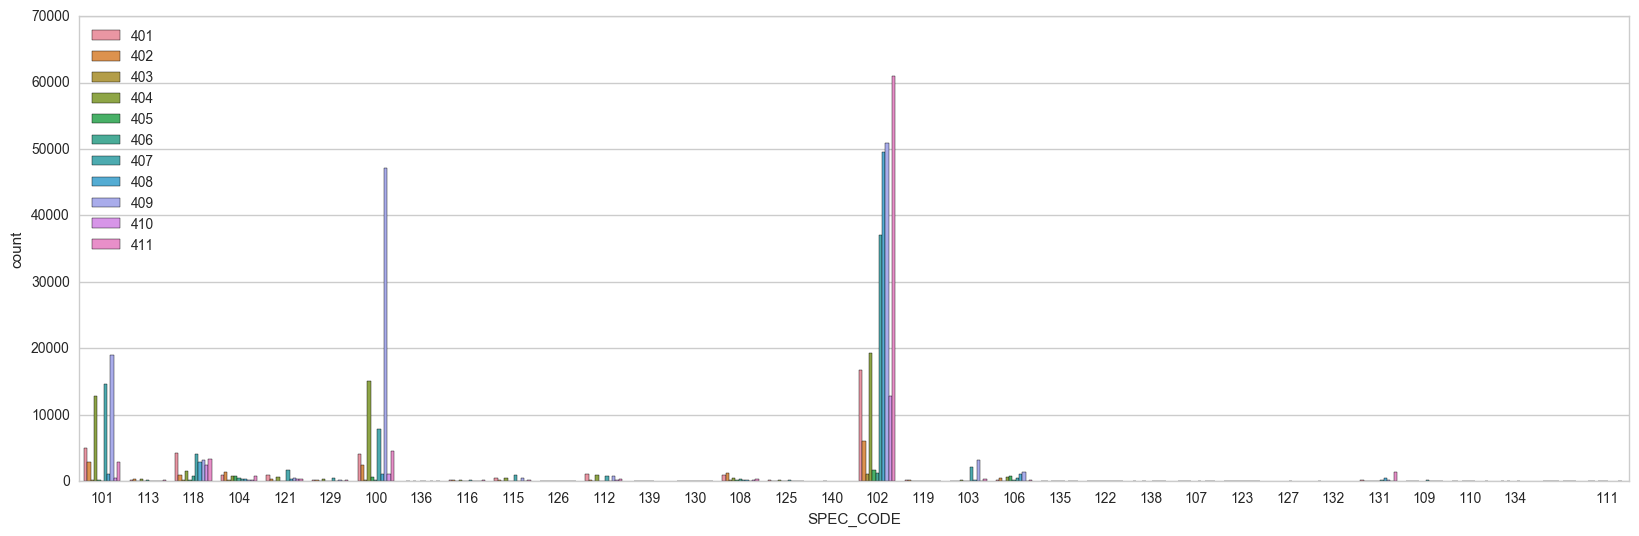

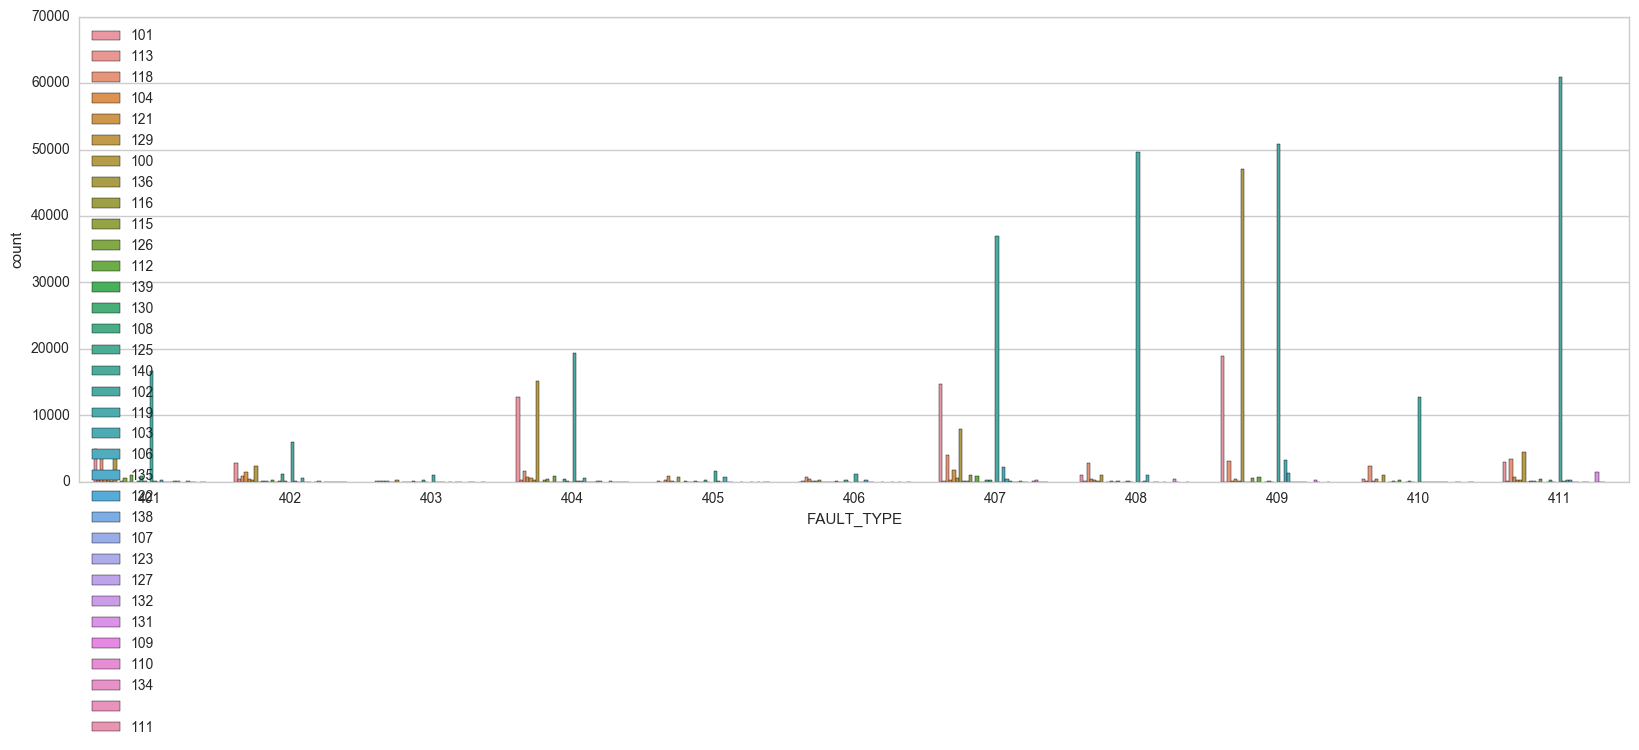

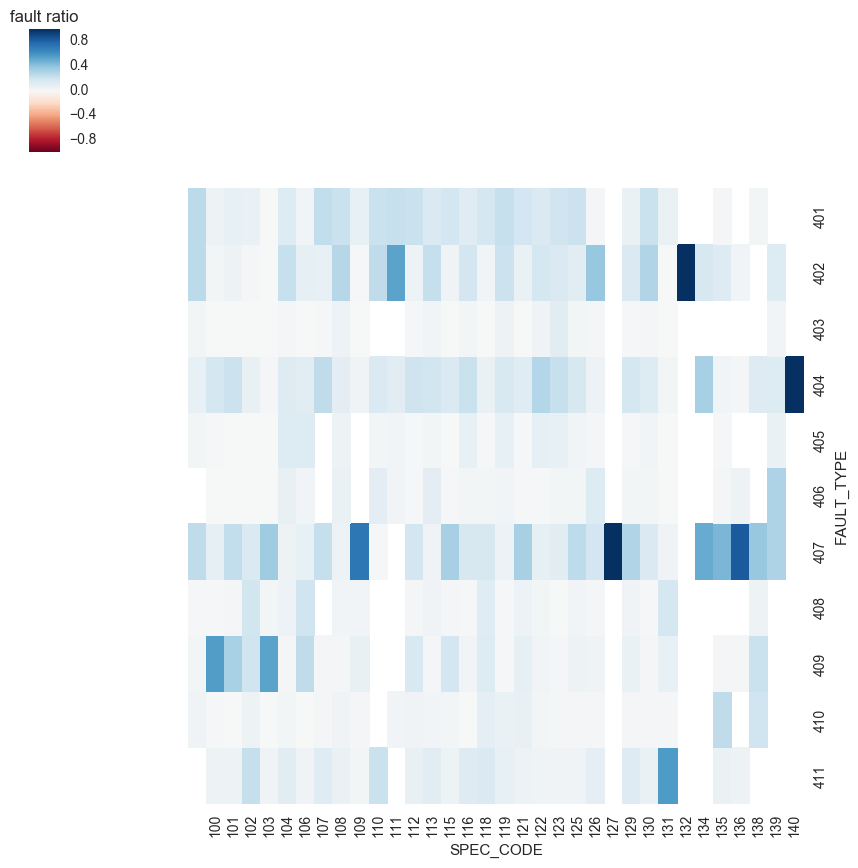

In [11]:
if PLOT:
    plot_fun('SPEC_CODE', 'FAULT_TYPE',figsize=(20,6))

spec_freq = data['SPEC_CODE'].value_counts().index[data['SPEC_CODE'].value_counts().values<100]
#spec_mapping = {label:idx for label,idx in zip(spec_freq, np.zeros(len(spec_freq)))}
print spec_freq.values

In [12]:
data['SPEC_CODE'].value_counts()
data['SPEC_CODE'] = data['SPEC_CODE'].replace(spec_freq.values, 0)
print data['SPEC_CODE'].value_counts()

102    257260
100     84538
101     58873
118     23678
104      6180
103      6031
106      5548
121      5265
112      4609
108      4276
115      2966
131      2543
129      1648
113      1448
116       996
125       846
119       535
0         460
109       313
123       295
130       222
107       203
122       107
Name: SPEC_CODE, dtype: int64


In [13]:
#get_dummies
SPEC_dummies = coo_matrix(pd.get_dummies(data['SPEC_CODE']))

## 设备规格故障类型统计
* 图1为设备规格数量分布图，分布呈现出故障在部分设备规格集中出现在5种设备规格中，102（2级单相费控智能电能表（远程-开关内置））最多，其他的占比较小。
* 图2为设备规格故障数量占比图，故障数据主要集中在5个设备规格，占比达90%以上
* 图3为设备规格-故障类型数量图，每个供电单位的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为设备规格-供电单位图，每种故障类型在每个设备规格的分布不同
* 图5为设备规格-故障类型占比图，可以看出每个设备规格故障类型比例，可以用于相似设备规格聚类
* 对数量小于100的设备规格类型进行合并
* 对属性做了二元变换处理

# MANUFACTURER

In [14]:
data['MANUFACTURER'].value_counts()
print len(data['MANUFACTURER'].value_counts())

127


In [15]:
spec_freq = data['MANUFACTURER'].value_counts().index[data['MANUFACTURER'].value_counts().values<500]
data['MANUFACTURER'] = data['MANUFACTURER'].replace(spec_freq.values, 0)
print len(data['MANUFACTURER'].value_counts())

73


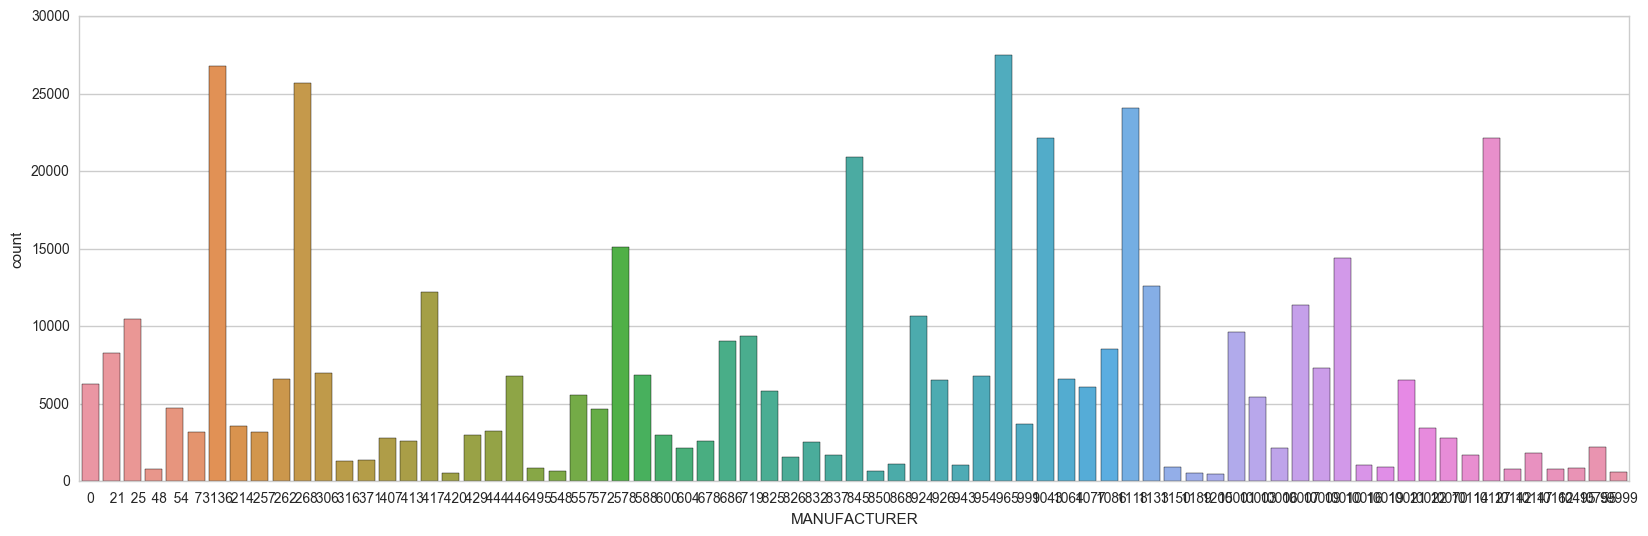

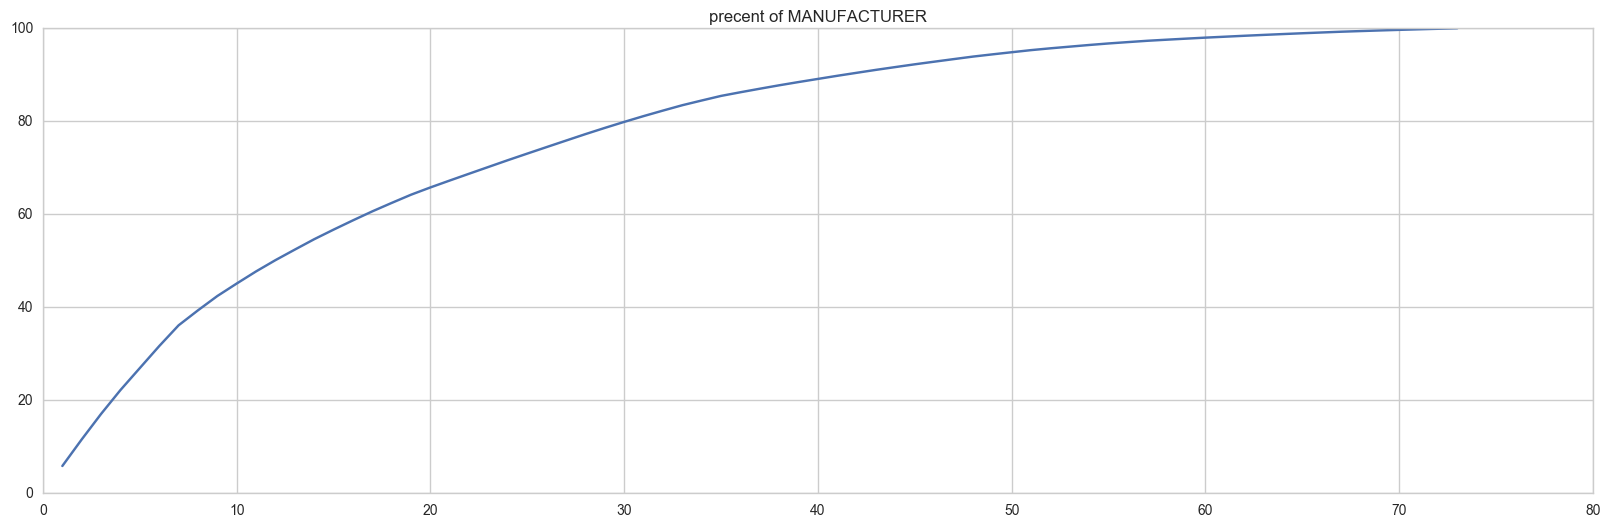

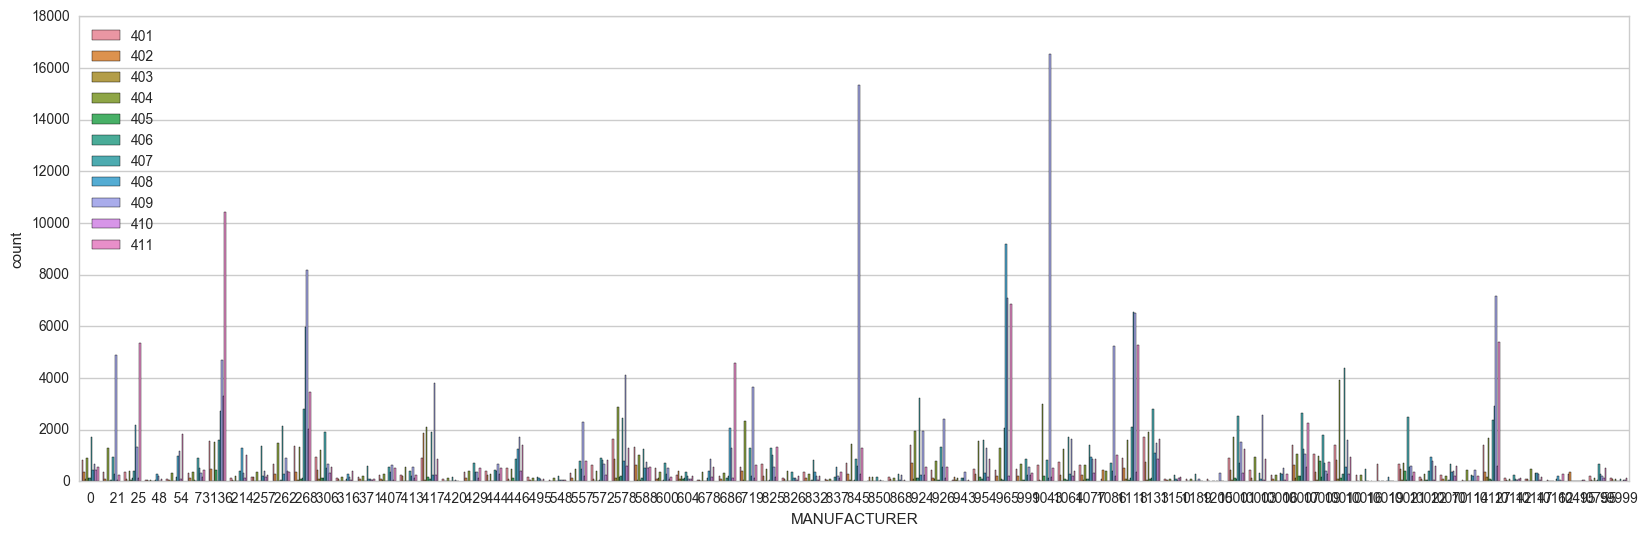

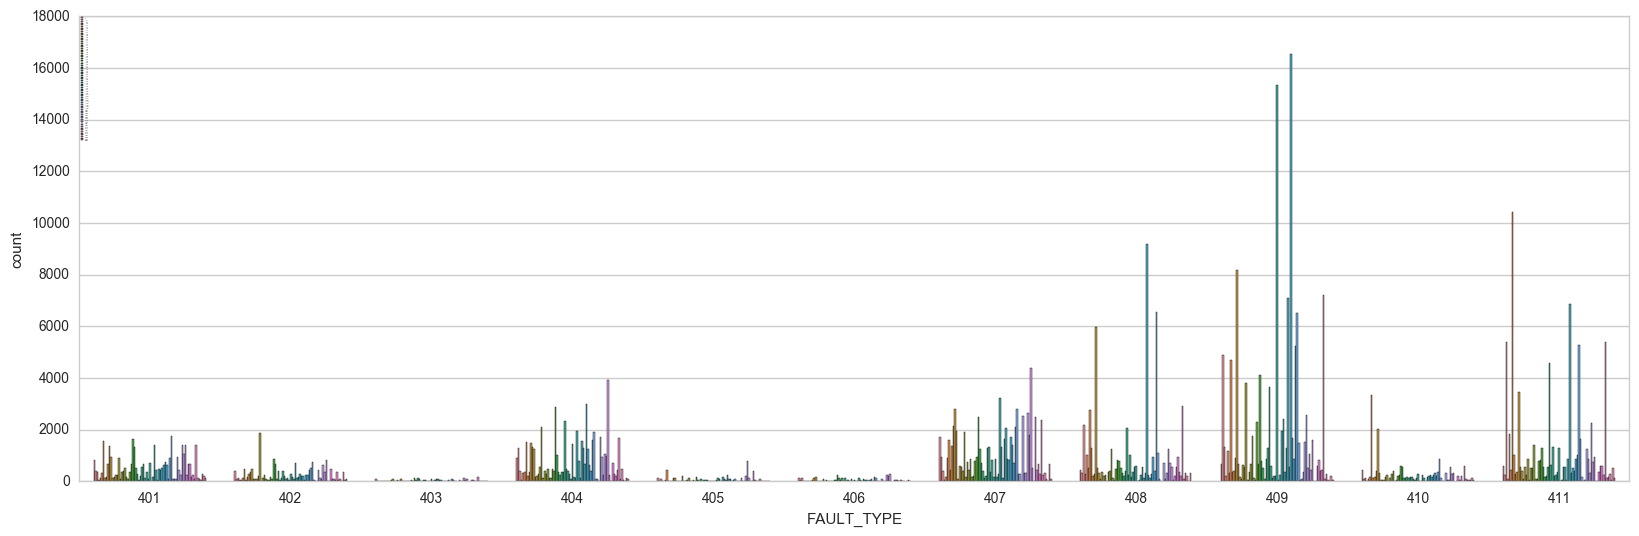

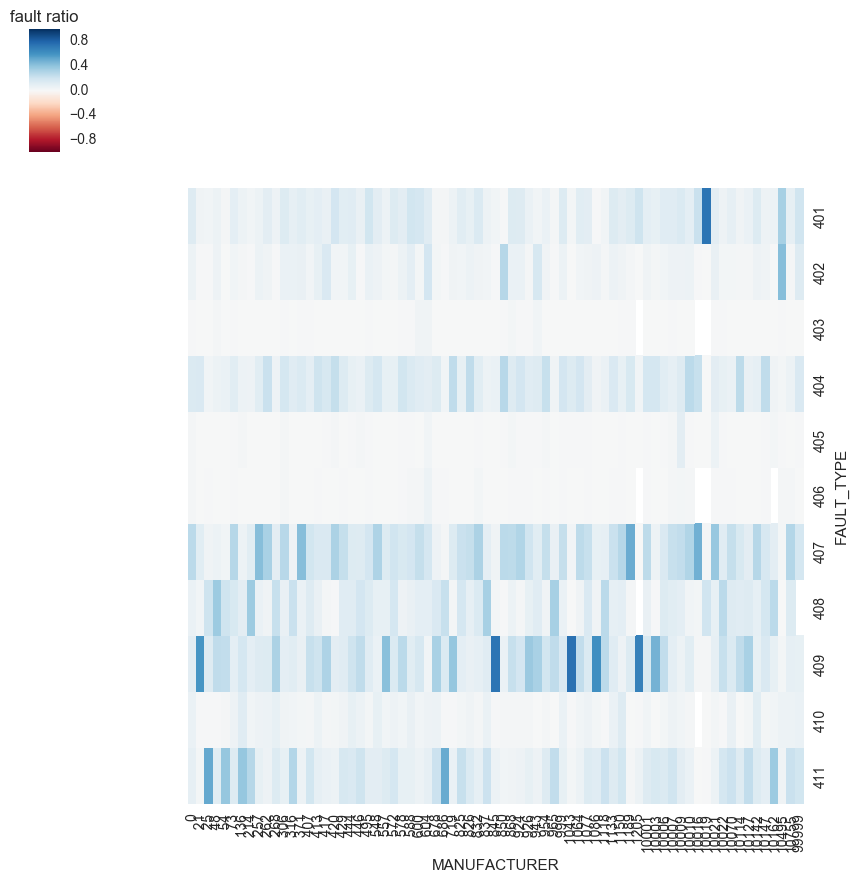

In [16]:
#plot
if PLOT:
    plot_fun('MANUFACTURER', 'FAULT_TYPE',figsize=(20,6), fontsize=1)

#get_dummies
MAN_dummies = coo_matrix(pd.get_dummies(data['MANUFACTURER']))

In [17]:
import gc
gc.collect()

279033

## 设备供应商故障类型统计
* 图1为设备供应商数量分布图，设备供应商不集中，数量大于500的有78家
* 图2为设备供应商数量占比图，供应商数量分布相对比较均匀
* 图3为设备供应商-故障类型数量图，每个设备供应商的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为设备供应商-供电单位图，每种故障类型在每个设备供应商的分布不同
* 图5为设备供应商-故障类型占比图，可以看出每个设备供应商故障类型比例，可以用于相似设备供应商聚类
* 对数量小于500的设备供应商类型进行合并
* 对属性做了二元变换处理

# COMM_MODE

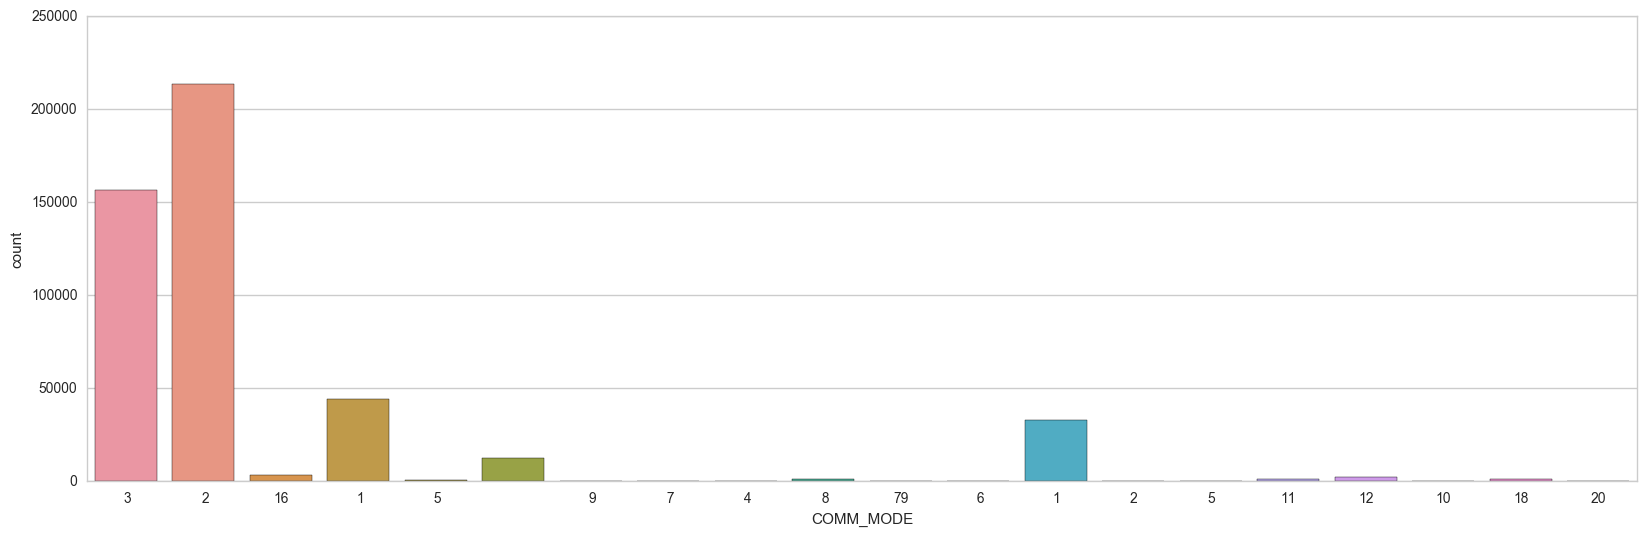

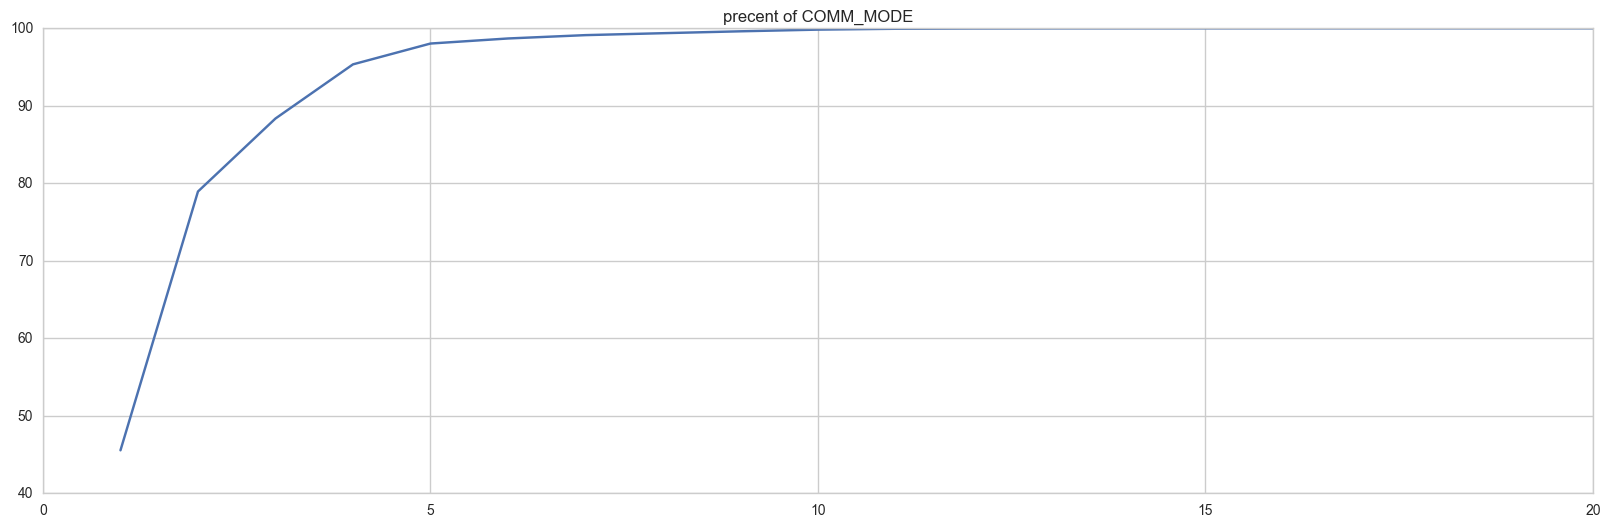

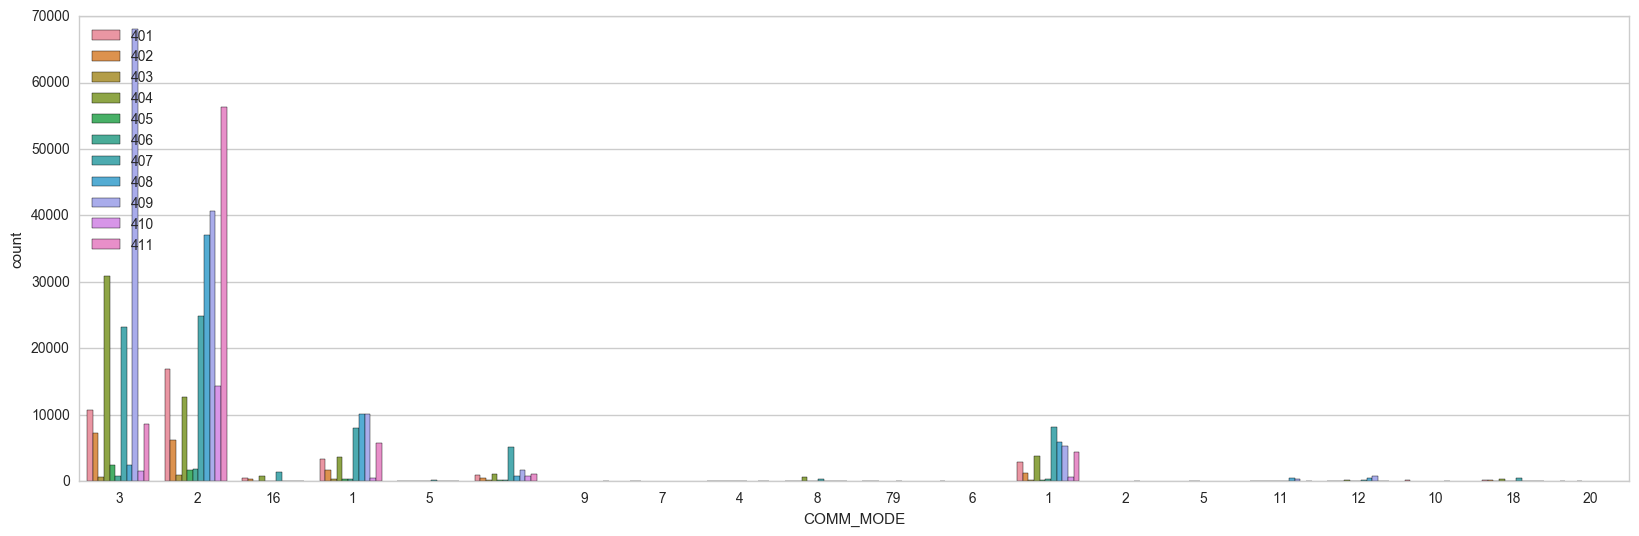

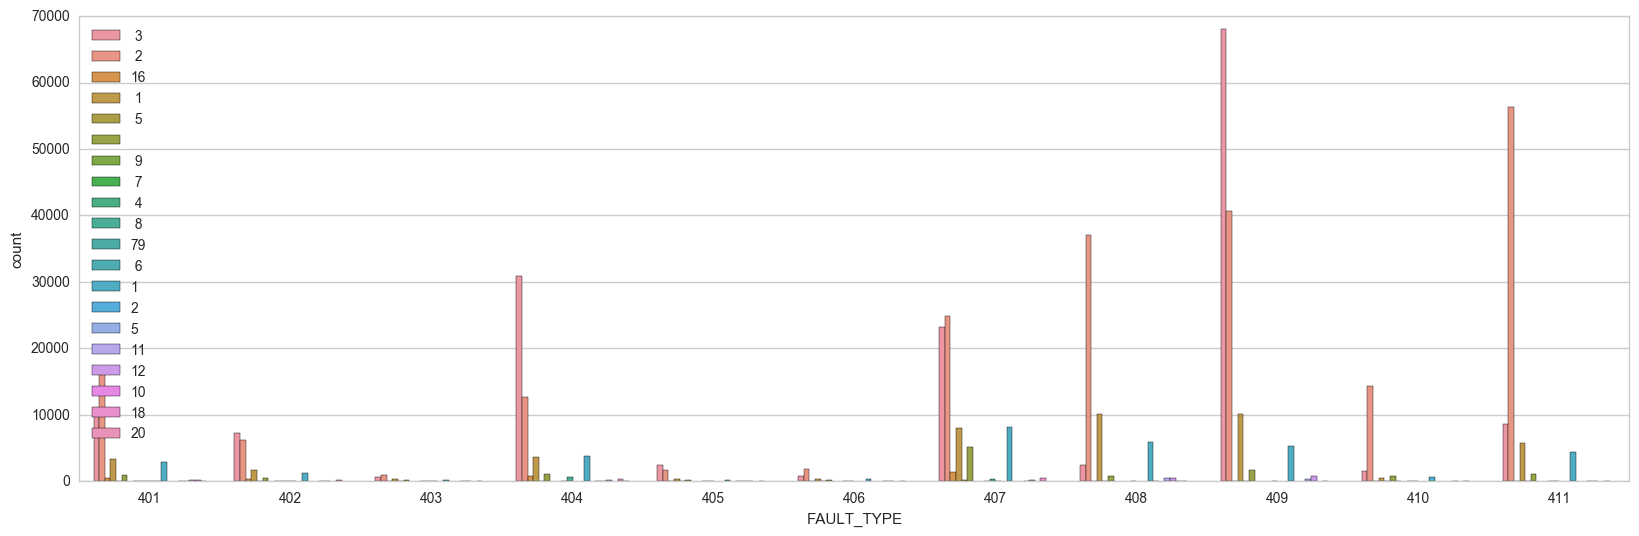

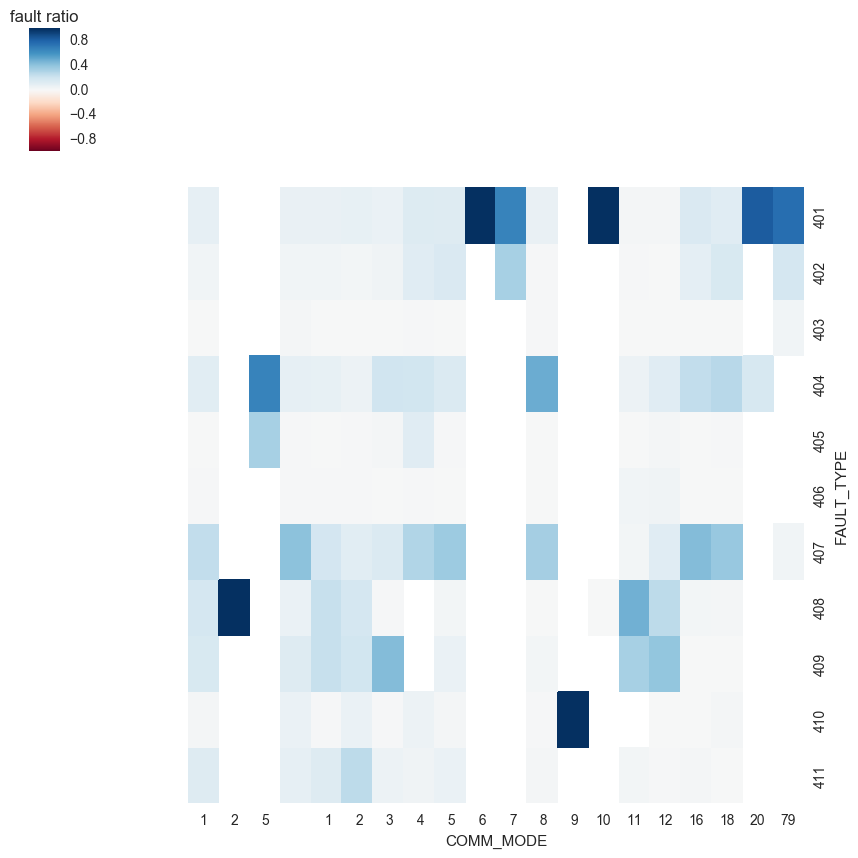

In [18]:
data['COMM_MODE'].value_counts()

if PLOT:
    plot_fun('COMM_MODE', 'FAULT_TYPE',figsize=(20,6))

COMM_freq = data['COMM_MODE'].value_counts().index[data['COMM_MODE'].value_counts().values<100]
data['COMM_MODE'] = data['COMM_MODE'].replace(COMM_freq.values, 0)
COMM_dummies = coo_matrix(pd.get_dummies(data['COMM_MODE']))# 转化为稀疏矩阵

## 通讯方式-故障类型统计
* 图1为通讯方式数量分布图，主要集中于四种，且确实数据较多
* 图2为通讯方式数量占比图，通信方式数量主要集中于四种，占90%
* 图3为通讯方式-故障类型数量图，每个通讯方式的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为通讯方式-供电单位图，每种故障类型在每个通讯方式的分布不同
* 图5为通讯方式-故障类型占比图，可以看出每个通讯方式故障类型比例，可以用于相似通讯方式聚类
* 对数量小于100的通讯方式类型进行合并
* 对属性做了二元变换处理

# 工作时长

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


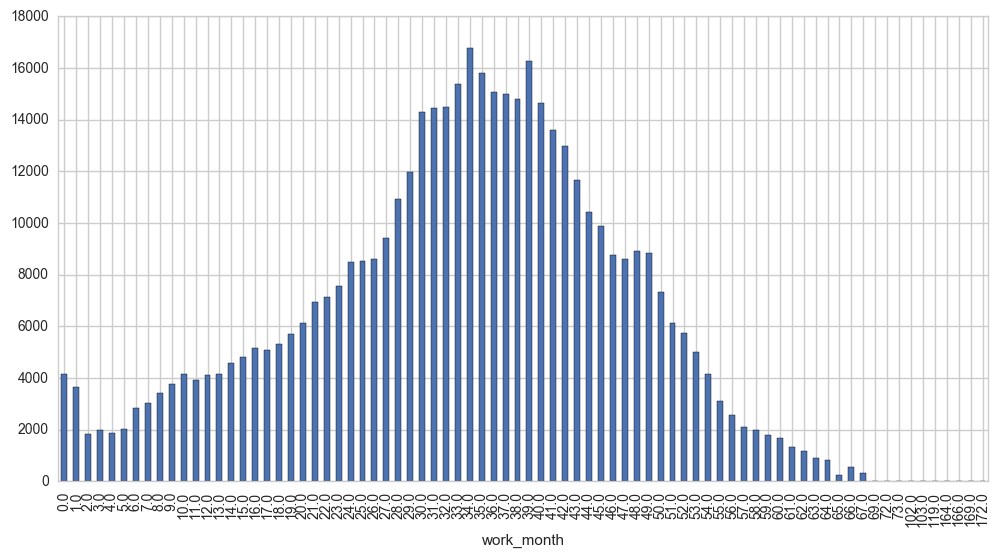

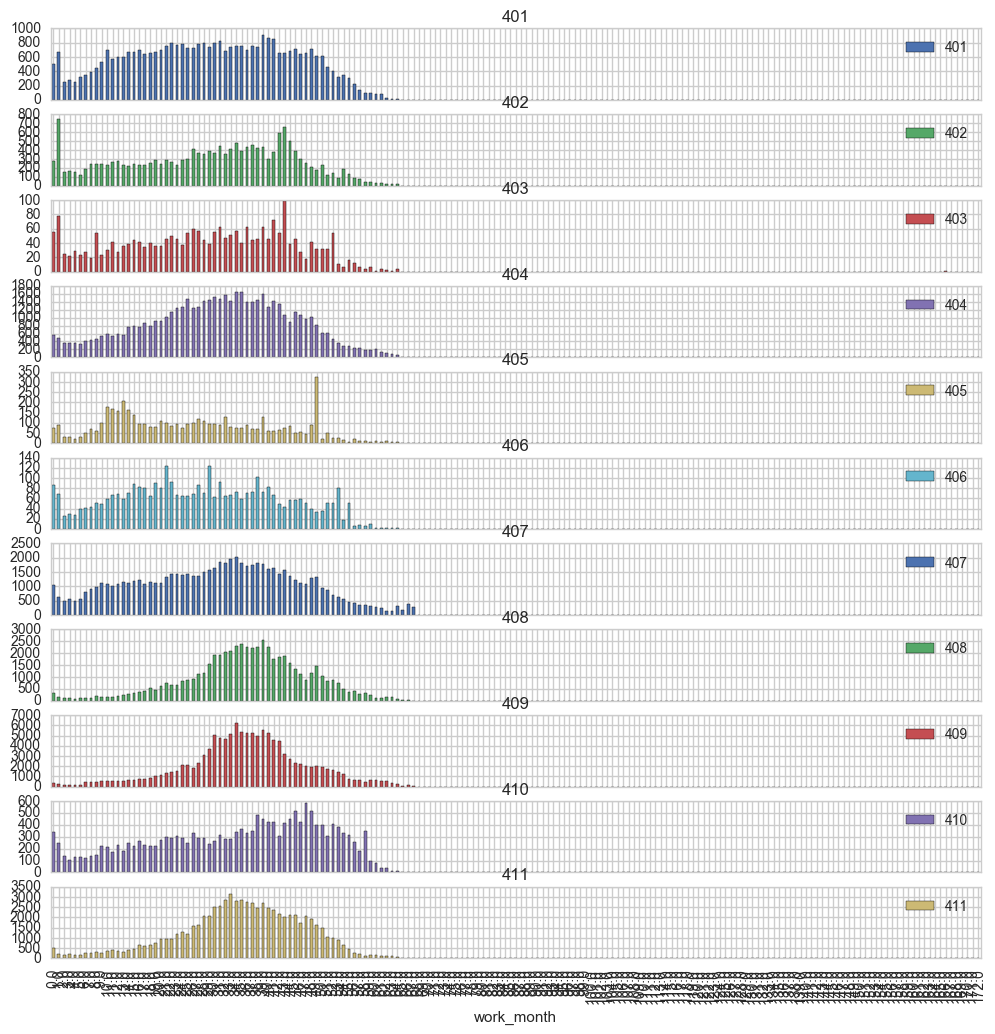

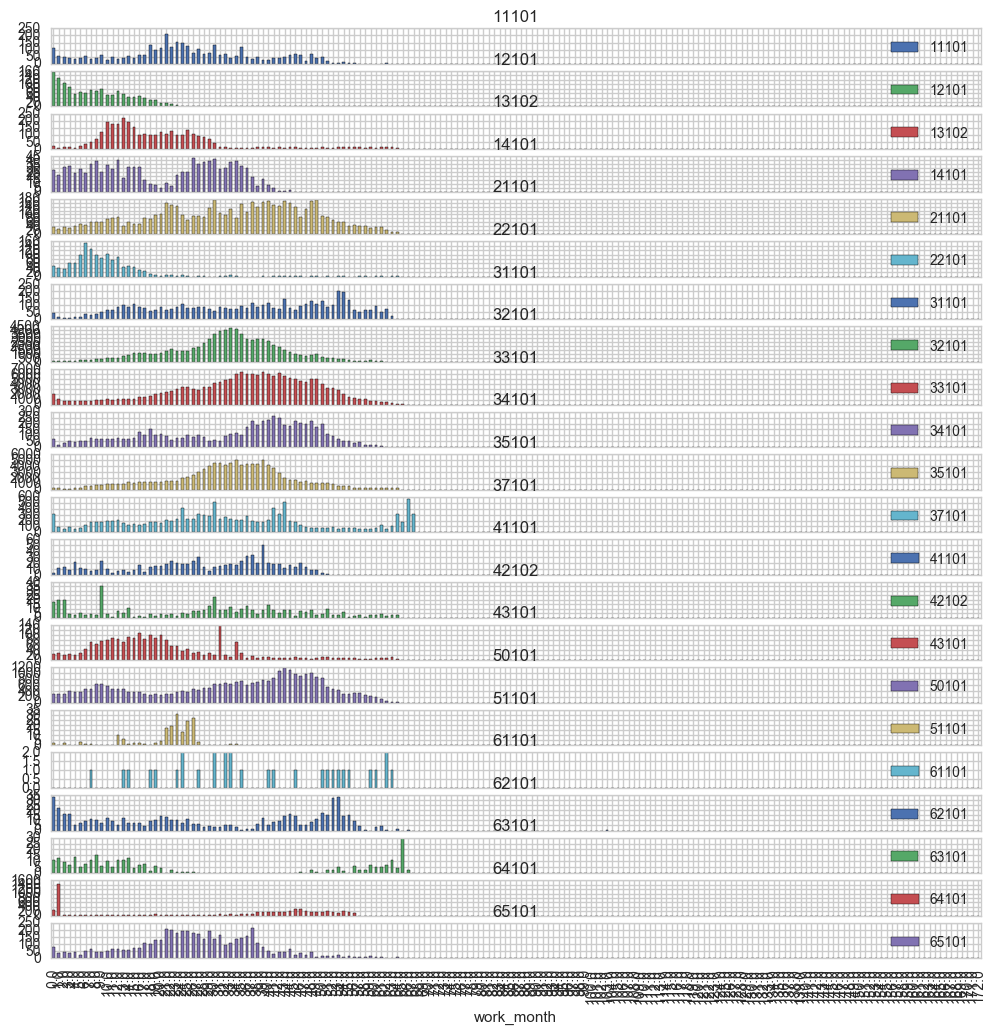

In [19]:

# use month distribution
if PLOT:
    c1 = data.groupby(['work_month']).size()
    c1.plot(kind='bar', figsize=(12, 6))

    c2 = data.groupby(['work_month', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.work_month.min(), data.work_month.max()+1)).fillna(0)
    c2.plot(kind='bar', figsize=(12, 12), subplots=True)

    c3 = data.groupby(['work_month', 'SYNC_ORG_NO']).size().unstack().reindex(index=np.arange(data.work_month.min(), data.work_month.max()+1)).fillna(0)
    c3.plot(kind='bar', figsize=(12, 12), subplots=True)
    
#归一化

min_max_scaler = preprocessing.MinMaxScaler()
data['work_month'] = min_max_scaler.fit_transform(data['work_month'])

## 使用寿命-故障类型统计
- 对全国故障电表使用寿命进行了统计，可看出其分布基本为正态分布，均值在37个月，符合客观规律。
- 使用寿命-故障类型图显示了每种故障类型的使用寿命分布情况，基本为正态分布，但是其分布参数有所不同，可以用来作为分类特征。
- 使用寿命-省份分布图，不同省份的使用寿命分布有区别，可以得出供电所对电表使用寿命有影响。

# 故障月份

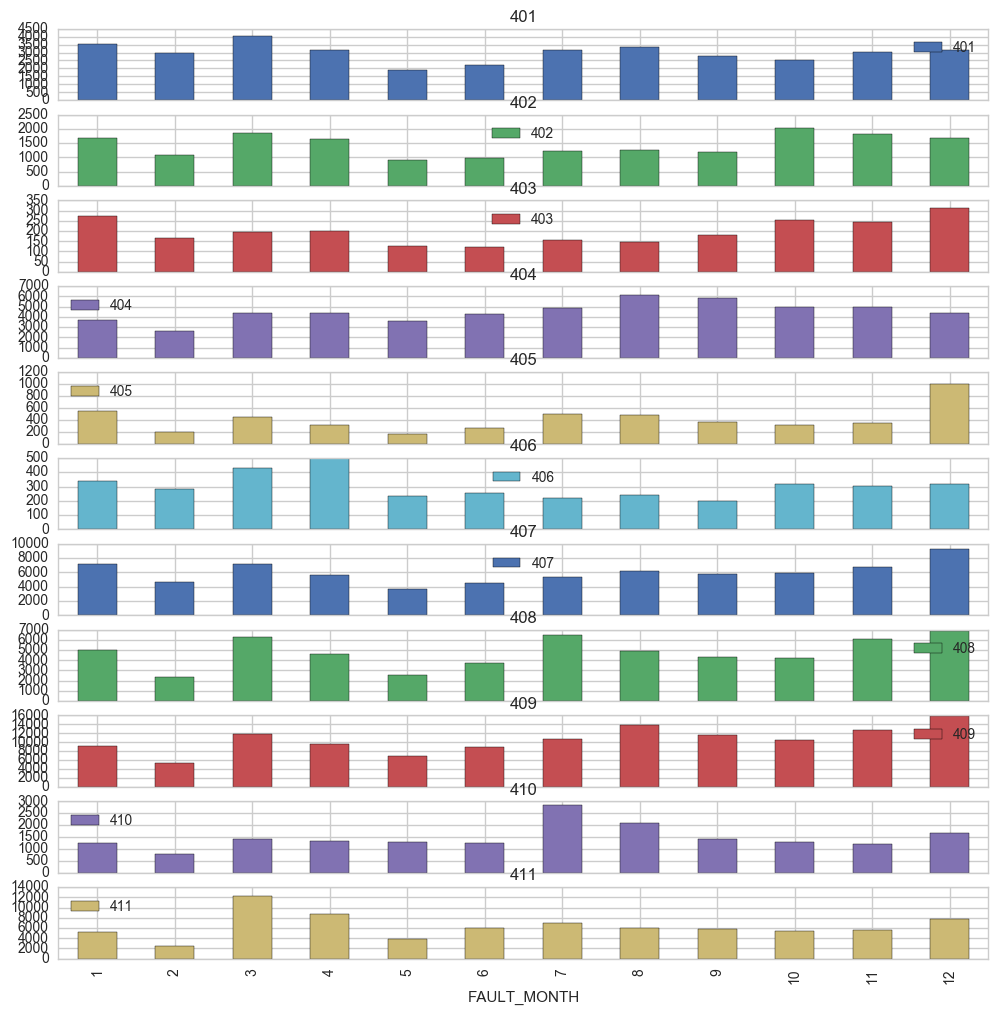

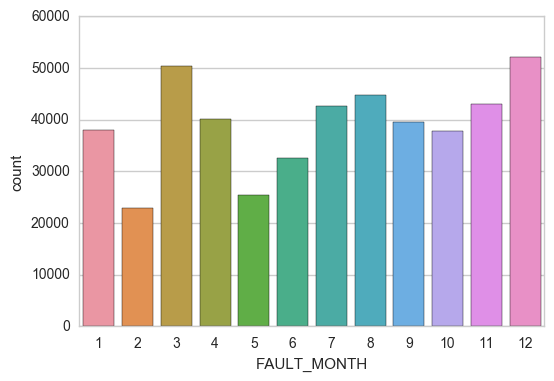

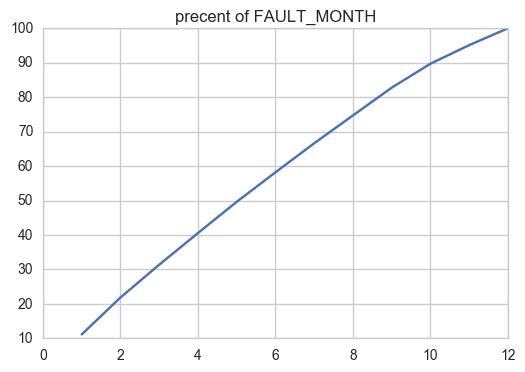

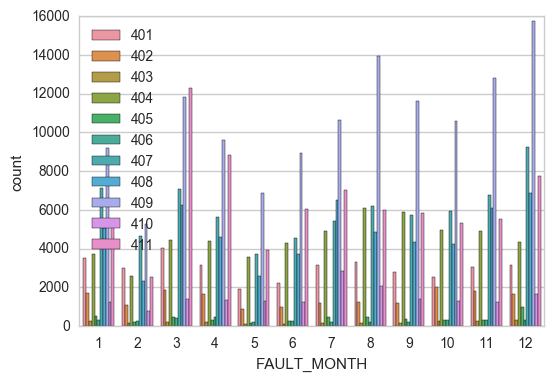

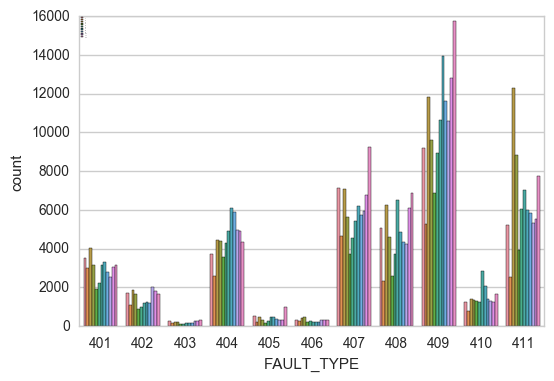

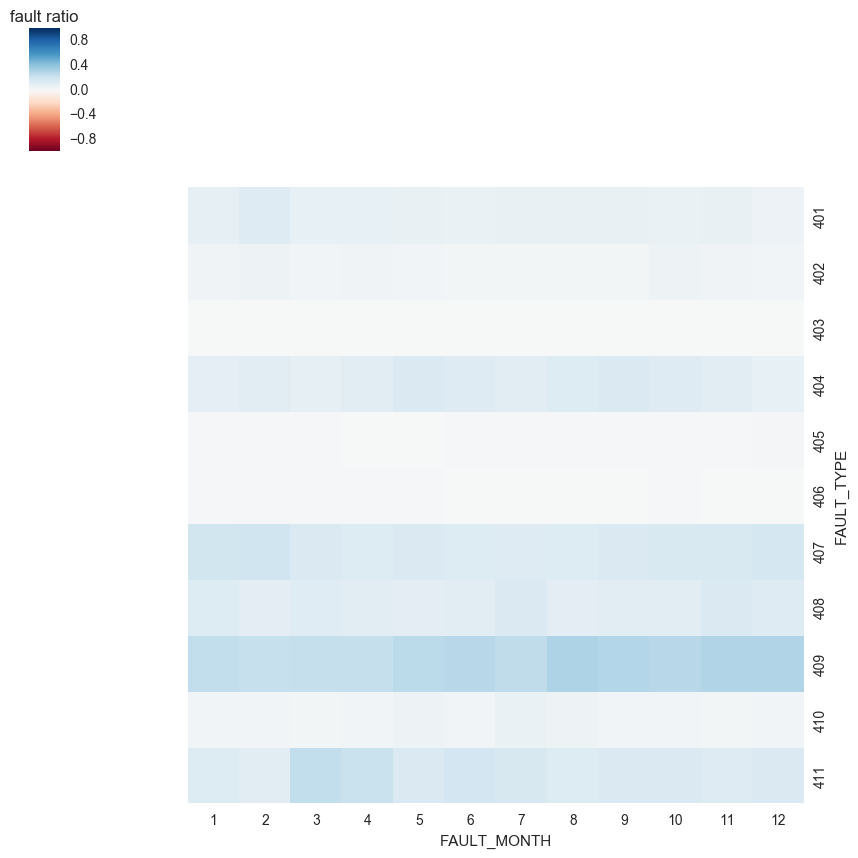

In [20]:
data['FAULT_MONTH'] = pd.Categorical(data['FAULT_MONTH'], ordered=True)
if PLOT:
    m1 = data.groupby(['FAULT_MONTH', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.FAULT_MONTH.min(), data.FAULT_MONTH.max()+1)).fillna(0)
    m1.plot(kind='bar', figsize=(12, 12), subplots=True)
    plot_fun('FAULT_MONTH', 'FAULT_TYPE', fontsize=1)

#get_dummies
FAUMON_dummies = coo_matrix(pd.get_dummies(data['FAULT_MONTH']))

data['INST_MONTH'] = pd.Categorical(data['INST_MONTH'], ordered=True)
INSMON_dummies = coo_matrix(pd.get_dummies(data['INST_MONTH']))
#

## 故障月份-故障类型统计
- 故障月份-故障数量统计表显示了不同月份故障数量的分布，分布基本均匀
- 故障月份-故障类型图显示了每月的故障类型分布情况，每个月的故障类型占比基本相似，是比较弱的分类特征。
- 故障月份-故障类型分布图，不同月份故障类型占比基本相似。

# 库存时间
* 库存时间 = 安装时间 - 检定时间

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


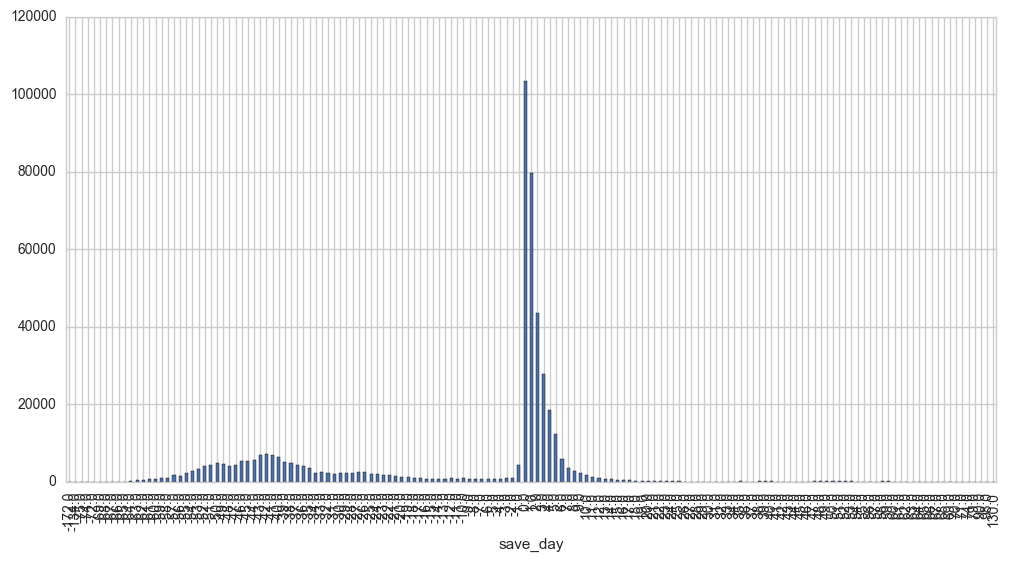

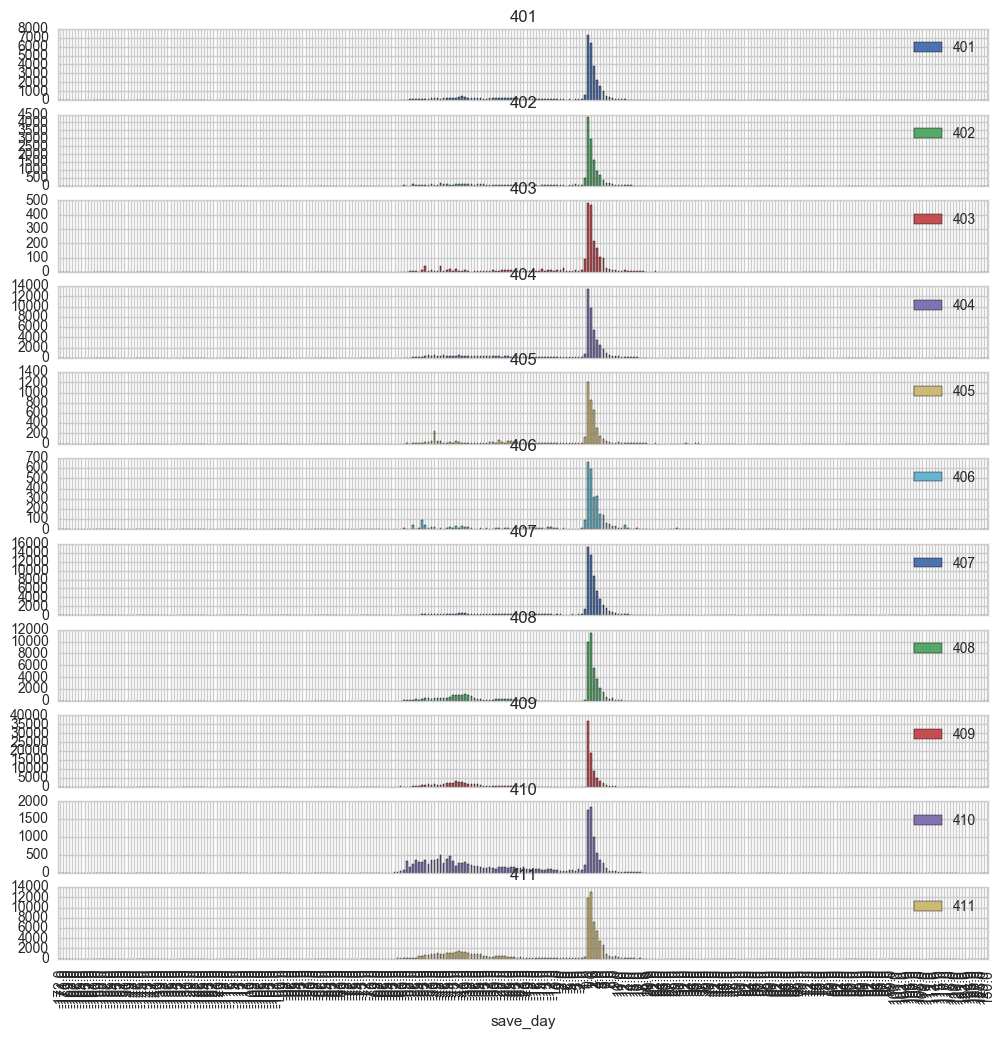

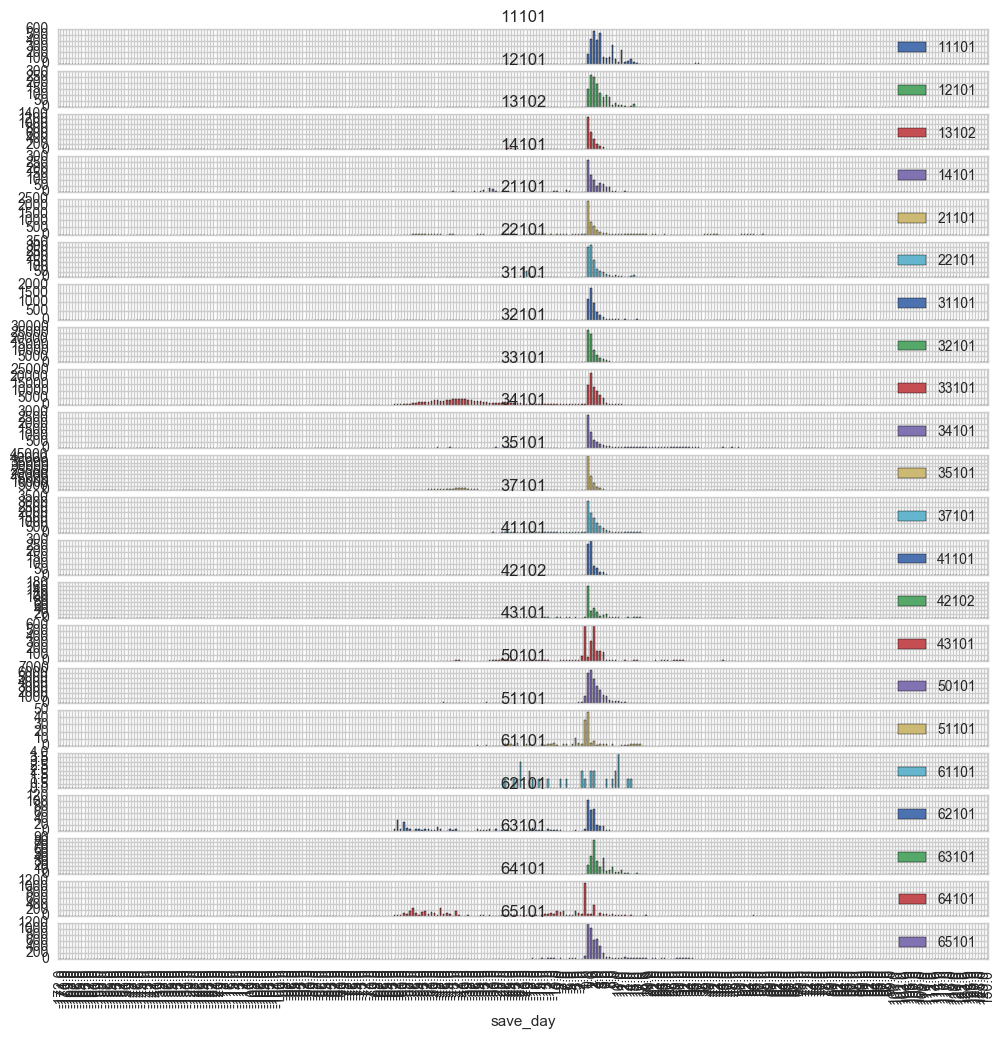

In [21]:
if PLOT:
    c1 = data.groupby(['save_day']).size()
    c1.plot(kind='bar', figsize=(12, 6))

    c2 = data.groupby(['save_day', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.save_day.min(), data.save_day.max()+1)).fillna(0)
    c2.plot(kind='bar', figsize=(12, 12), subplots=True)

    c3 = data.groupby(['save_day', 'SYNC_ORG_NO']).size().unstack().reindex(index=np.arange(data.save_day.min(), data.save_day.max()+1)).fillna(0)
    c3.plot(kind='bar', figsize=(12, 12), subplots=True)
    
#归一化
min_max_scaler = preprocessing.MinMaxScaler()
data['save_day'] = min_max_scaler.fit_transform(data['save_day'])

# 批次

In [22]:
len(data['ARRIVE_BATCH_NO'].value_counts())

16668

258


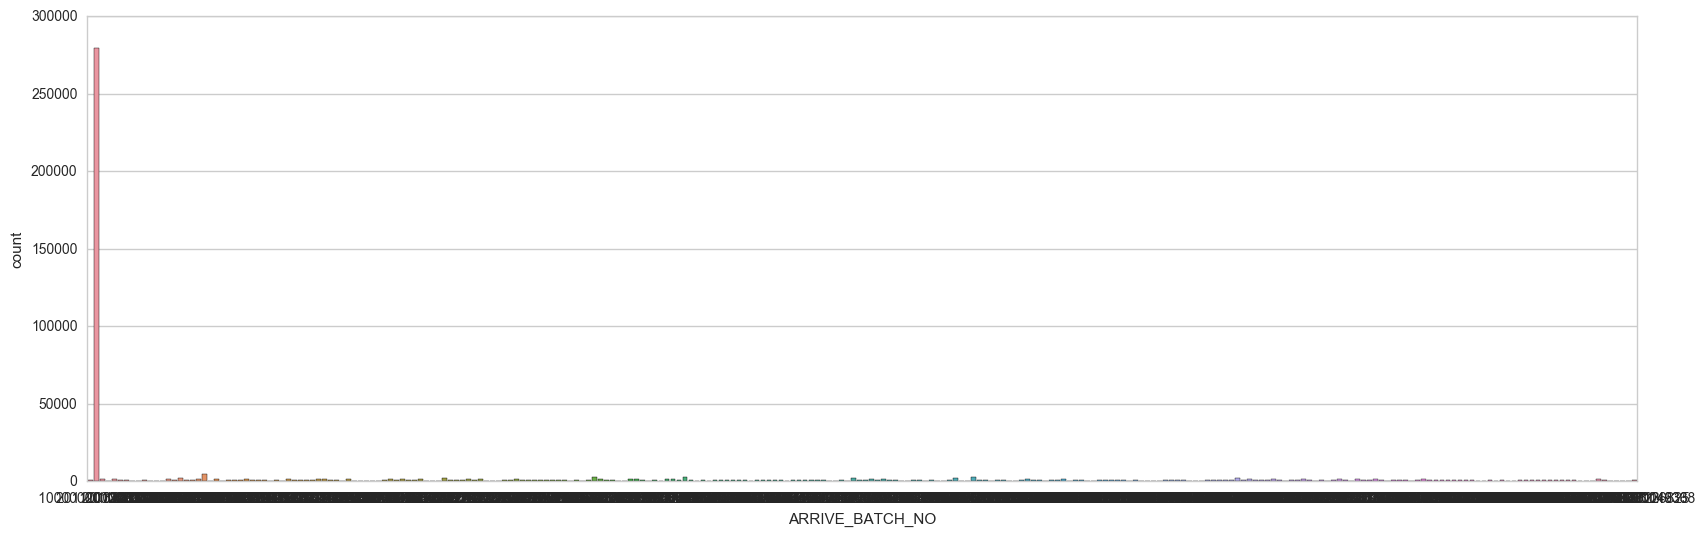

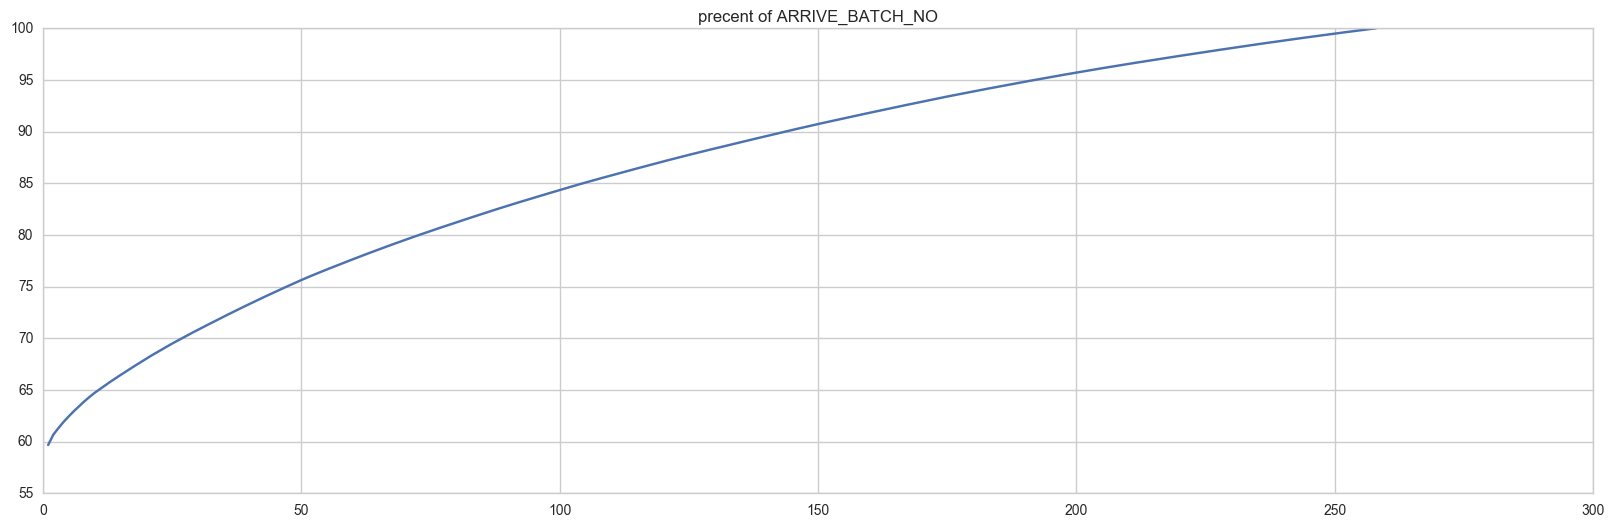

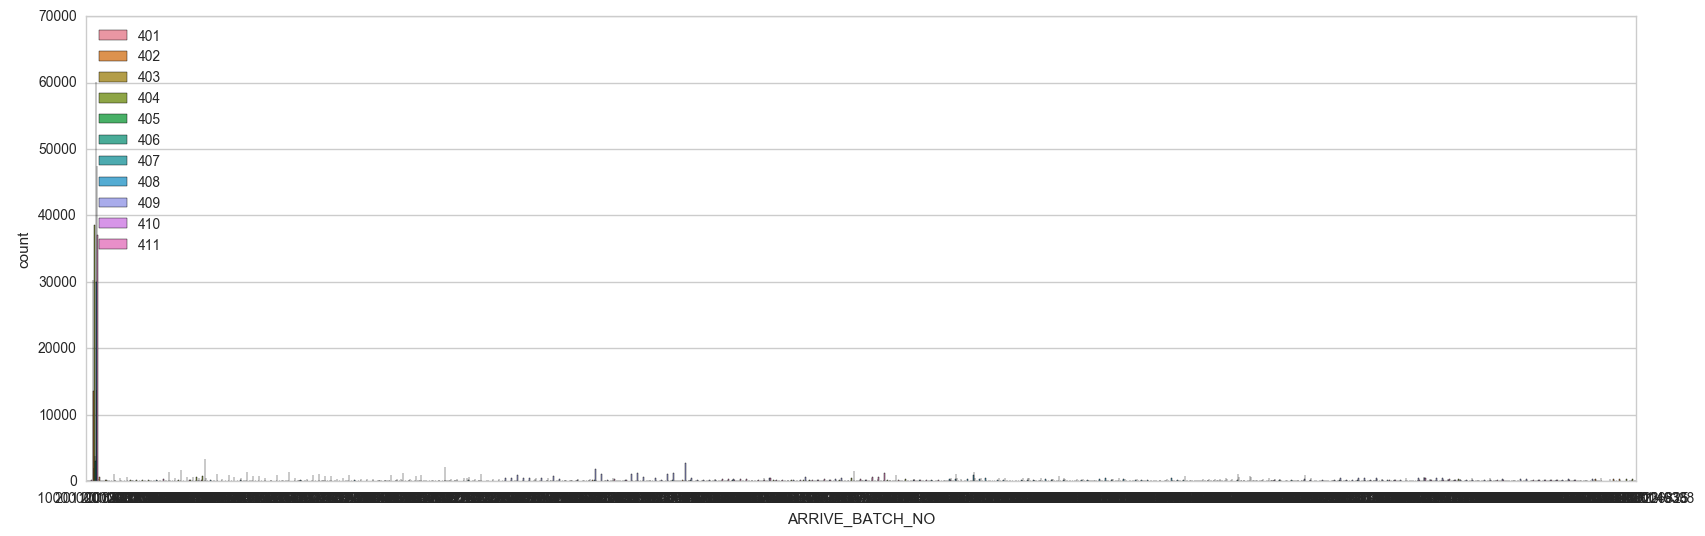

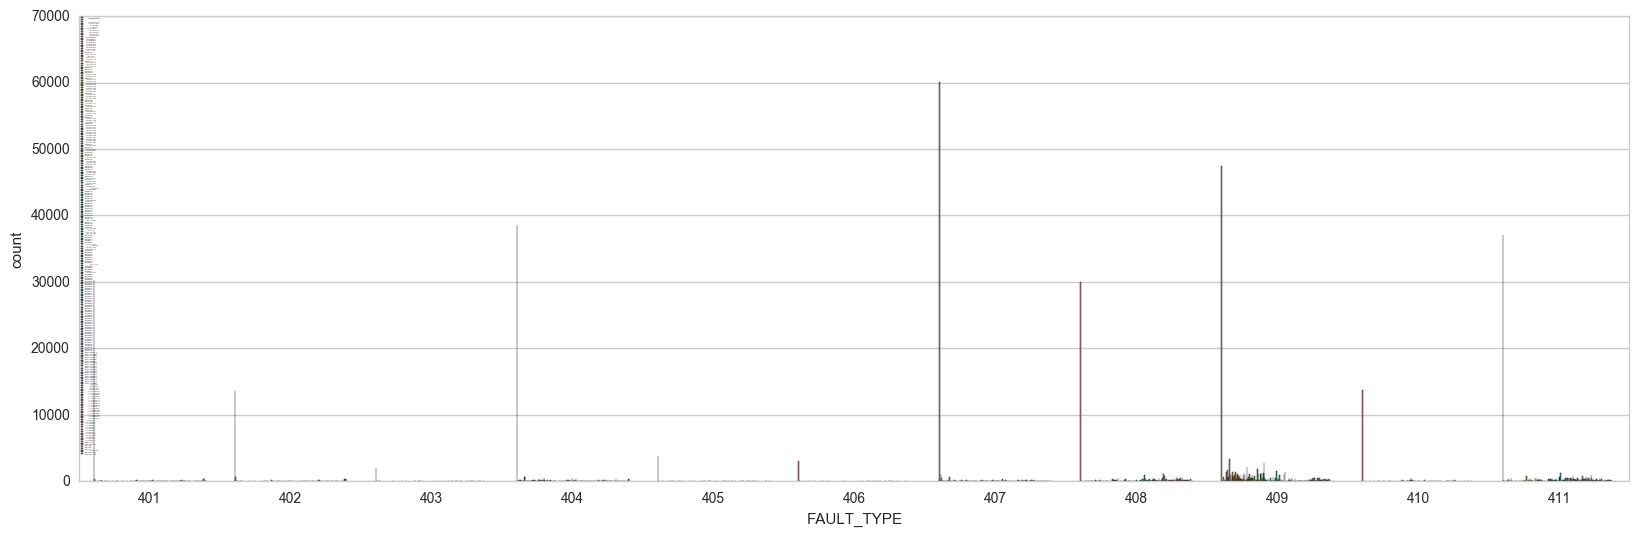

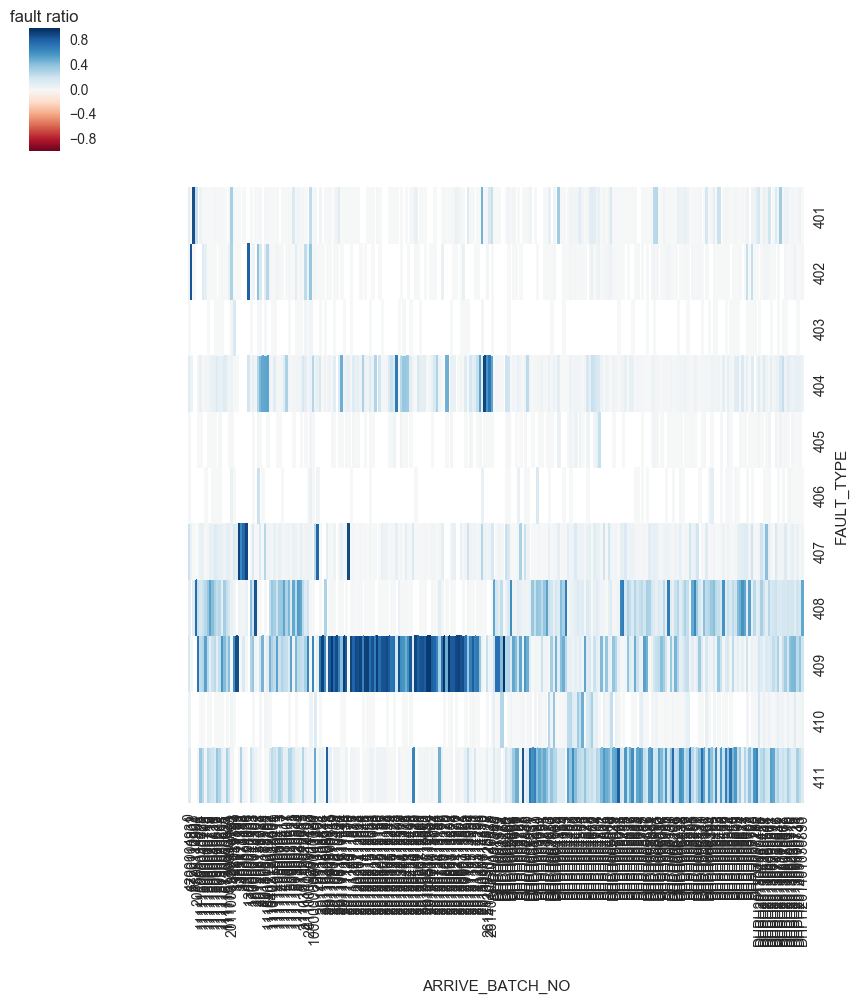

In [23]:
#cluster_encoding('ARRIVE_BATCH_NO')

arr_freq = data['ARRIVE_BATCH_NO'].value_counts().index[data['ARRIVE_BATCH_NO'].value_counts().values<300]
data['ARRIVE_BATCH_NO'] = data['ARRIVE_BATCH_NO'].replace(arr_freq.values, 0)
print len(data['ARRIVE_BATCH_NO'].value_counts())

#plot
if PLOT:
    plot_fun('ARRIVE_BATCH_NO', 'FAULT_TYPE',figsize=(20,6), fontsize=1)

#get_dummies
arr_dummies = coo_matrix(pd.get_dummies(data['ARRIVE_BATCH_NO']))

In [24]:
data['ARRIVE_BATCH_NO'].value_counts()

0                           279767
      2011111401              4689
   2012090313521              3015
DHPH005896                    2792
   2012072613167              2534
   2012032712302              2373
   2012120514190              2228
   2011080210359              2159
DHPH006674                    2000
DHPH005787                    1878
DHPH201306090571              1674
   2012031512249              1672
   2011030908918              1623
DHPH005064                    1565
         111040212032602      1535
   2012011711968              1523
        2011000920914723      1516
   2011112911570              1471
   2012080813282              1463
DHPH006702                    1456
DHPH201304010415              1437
DHPH201309170745              1370
   2012083113502              1353
   2012041312419              1345
              3403873888      1339
   2012032012274              1273
DHPH201308070677              1267
   2011081610490              1261
DHPH006034          

* 批次属性由于在后续供应商供货不会再出现相同批次所以对故障预测的影响不大
* 批次数量主要集中在300以下(一共16668种批次,故障数据量在300以上的只有以上接近200种)

In [25]:
arr_dummies

<468840x258 sparse matrix of type '<type 'numpy.uint8'>'
	with 468840 stored elements in COOrdinate format>

In [26]:
#整合数据
data = data.join(pd.DataFrame(bmat([[SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies, arr_dummies]]).toarray()))
data.drop(['FAULT_MONTH','SYNC_ORG_NO', 'ORG_NO', 'SPEC_CODE', 'MANUFACTURER', 'FAULT_TYPE_1', 'FAULT_DATE1', 
           'INST_DATE1', 'COMM_MODE', 'INST_MONTH'], axis=1, inplace=True)

del SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies, arr_dummies

In [27]:
data.drop(['ARRIVE_BATCH_NO'], axis=1, inplace=True)

In [28]:
data.drop(['ORG_NAME', 'DETECT_DATE1'], axis=1, inplace=True)

## 机器学习算法故障预测

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
from scipy.sparse import csc_matrix
data_X = data.drop(['FAULT_TYPE'], axis=1)
data_y = data['FAULT_TYPE']
data_X = csc_matrix(data_X) 
#encode label
le = preprocessing.LabelEncoder()
data_y = le.fit_transform(data_y)
'''
data_X1 = coo_matrix(data_X.ix[:200000]) 
data_X2 = coo_matrix(data_X.ix[200001:400000])
data_X3 = coo_matrix(data_X.ix[400001:])
data_X4 = bmat([[data_X1], [data_X2], [data_X3]], format='coo')
'''
#del data_X1, data_X2, data_X3
train, test, train_y, test_y = train_test_split(data_X, data_y, test_size=0.33, random_state=27)


In [30]:
import gc
gc.collect()

102

# XGBoost

In [31]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

TRAIN = True  #是否训练
CV = False
#split train set and test set
dtrain = xgb.DMatrix(data_X, data_y)
dtest = xgb.DMatrix(test)

clf = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 1200,
    max_depth = 9,
    colsample_bytree = 0.8,
    subsample = 0.9,
    objective = 'multi:softprob',
    min_child_weight = 1,
    gamma = 2,
    seed = 27
    )

param = clf.get_xgb_params()
param['num_class'] = 11
if CV:
    cvresult = xgb.cv(param, dtrain, num_boost_round=2000, nfold=10, stratified=True,
                  metrics='merror', early_stopping_rounds=10,verbose_eval=True)
    clf.set_params(n_estimators=cvresult.shape[0])   #set n_estimators as cv rounds
if TRAIN:
    clf.fit(data_X, data_y, eval_metric='merror')
else:
    clf = pickle.load(open("zhejiang_4_all.pkl", "rb"))
        

In [32]:
ypred_xgb = clf.predict(test)
ypred_xgb = le.inverse_transform(ypred_xgb)
test_y_xgb = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_xgb, ypred_xgb))
print(confusion_matrix(test_y_xgb, ypred_xgb))
pickle.dump(clf, open("qg_4_all_jiaoliu_3.pkl", "wb"))


             precision    recall  f1-score   support

        401       0.66      0.55      0.60     11828
        402       0.70      0.56      0.62      5674
        403       0.78      0.36      0.50       757
        404       0.70      0.55      0.61     17939
        405       0.80      0.57      0.67      1652
        406       0.69      0.44      0.54      1224
        407       0.60      0.73      0.66     23566
        408       0.71      0.66      0.68     18782
        409       0.78      0.86      0.82     42165
        410       0.68      0.69      0.69      5903
        411       0.72      0.73      0.72     25228

avg / total       0.71      0.71      0.70    154718

[[ 6540   203     3   624    21    26  2131   394   918   363   605]
 [  247  3174    12   412    15    32   827   158   340   185   272]
 [   51    42   275    71     6     1   152    16    95    12    36]
 [  609   329    13  9777    29    48  3011   615  2516   186   806]
 [   52    69     5    74   940 

# TOPN 推荐

In [33]:
def result(N, test, test_true_y):
    ypred_pro = clf.predict_proba(test)
    ypred_sort = np.argsort(ypred_pro, axis=1)  # sort pro index
    true_sum = sum((test_true_y.reshape((-1, 1)) == ypred_sort[:,-N:]).any(1))
    precision = float(true_sum) / len(test_y)
    print 'number of output:%d,\n precision:%f'%(N, precision)
    
result(2, test, test_y)
result(3, test, test_y)

number of output:2,
 precision:0.865581
number of output:3,
 precision:0.927856


* TOPN计算过程为:推送概率最高的N种故障,如果真是故障为这N种故障中的一种即认为正确
* 正确率: TOP2:0.865  TOP3:0.927
* TOPN推荐方式在3个时正确率较高,对于提高工作效率较有意义

In [ ]:
clf.booster().dump_model('../model/xgbtree.txt')
clf.booster().save_model('../model/xgb.model')

* 召回率(Recall)=  系统检索到的相关文件 / 系统所有相关的文件总数
* 准确率(Precision) =  系统检索到的相关文件 / 系统所有检索到的文件总数
* f1 = 2*Recall*Precision / (Recall+Precision)

# 数据可视化

In [34]:
# t-SNE
def plot_embedding(X, title=None):
    global test_y
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], test_y[i], 
                color=plt.cm.Set1(test_y[i] / 11.))
        
    if title is not None:
        plt.title(title)
  

# t-SNE高维数据可视化

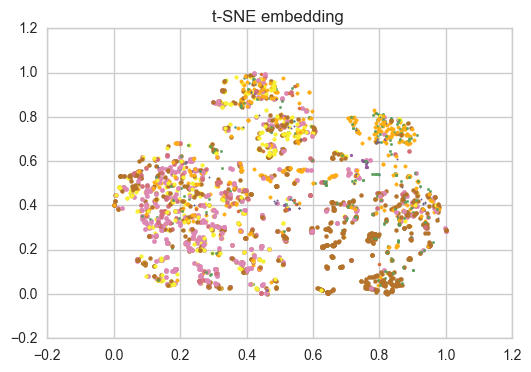

In [33]:
from sklearn import manifold, decomposition
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(test.toarray()[:3000])
plot_embedding(X_tsne, "t-SNE embedding ")
plt.show()

* 利用高维数据可视化算法将部分数据映射到二维空间中观察数据分布情况
* 每种颜色代表不同的故障类型,可见现有数据所体现的数据分布规律不明显(即每种故障类型应集中分布于一个或几个区域)
* 后续应想办法获取能更加能体现故障类型分布的数据,以提升模型在此类问题上的泛化能力(在训练中没有出现的故障数据上的预测能力),以适应各种可能出现的情况,这也是这阶段的模型的缺陷

## 下一步计划
* 对属性对于分类的重要程度进行分析
* 使用决策树模型对于在何种属性情况下会发生哪种大概率故障进行分析

# top 10 feature importance

In [ ]:
weight = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)[:10]
weight.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance weight Score')

In [ ]:
gain = pd.Series(clf.booster().get_score(importance_type='gain')).sort_values(ascending=False)[:10]
weight.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance gain Score')

In [ ]:
cover = pd.Series(clf.booster().get_score(importance_type='cover')).sort_values(ascending=False)[:10]
cover.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance cover Score')

In [ ]:
fig = plt.figure(figsize=(200,200), dpi=100)
ax2 = fig.add_subplot(111)
ax_xgb = xgb.plot_tree(clf,ax=ax2)
plt.savefig('../pic/tree1.png')